# Estimation of the effects of major events on the electricity prices in Germany using machine learning models
Notebook 04 modelling
___

### Table of Contents:
* [Introduction](#hading-1)
* [Train-validation split](#heading-2)
* [SARIMAX Model 1](#heading-3)
* [XGBoost Model 2](#heading-4)
* [XGBoost Model 3 ](#heading-5)
* [XGBboost final Model 4](#heading-6)
* [Forecast](#heading-7)
* [Predict into target area](#heading-8)
* [Findings](#heading-9)

### Introduction <a class="anchor" id="heading-1"></a>

We split the time period in the last notebook into two periods. We will now use the base area or train period to find the best model to predict the in the  target period.

![alt text](../images/image-5.png)

Since we will not have any quantitative indicators in the target period, we need to create a model that is as robust and accurate as possible based on the training period.

### Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX

import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import joblib 

plt.rcParams.update({'font.size': 13})

### Definition of functions

In [2]:

def decomposition_df(df, column, frequency='MS',aggregation_method='sum', type='additive'):
    '''
    Process a dataframe to decompose its time series data and add trend, seasonal, residual, and trend+seasonal columns.
    
    Parameters:
    - df: pandas DataFrame containing the data to be processed
    - column: the column to be processed in the dataframe
    - frequency: the frequency of the decomposition, default monthly 
        - D - daily
        - h- hourly
        - W- weekly 

        look here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    -aggregation_method: the method of the decomposition, default sum
        -mean
        -min
        -max


    -type: the used model in the decomposition, default = additive
        - multiplicative 
    
    
    Returns:
    - df_Frequency: the processed DataFrame with additional columns
    '''
    aggregation_func = getattr(pd.DataFrame, aggregation_method)
    df_Frequency=df[[column]].resample(frequency).apply(aggregation_func)
    decompositon= seasonal_decompose(df_Frequency[column], model=type)


    df_Frequency['Trend'] = decompositon.trend
    df_Frequency['Seasonal'] = decompositon.seasonal
    df_Frequency['Noise'] = decompositon.resid
    df_Frequency['Trend+Seasonal'] = df_Frequency['Seasonal'] + df_Frequency['Trend']

    return df_Frequency

In [3]:
def data_loading_train_and_test_and_set_index(df_name, base_path = '../data/'):
    '''
    loads the dataframe df from the base_path and set_the 'Start' column as the index in datetime format.

    df_name: expect a df Name for example Prices_FRA_hourly
    base_path default: '../data/' 

    return Prices_FRA_hourly
    '''
    
    file_path1 = f"{base_path}{df_name}_train.csv"
    df1= pd.read_csv(file_path1)
    if 'Unnamed: 0' in df1.columns:
        df1['Start'] = pd.to_datetime(df1['Unnamed: 0'])
        df1 = df1.drop(columns = 'Unnamed: 0')
        df1 = df1.set_index('Start')
    else:
        df1['Start'] = pd.to_datetime(df1['Start'])
        df1 = df1.set_index('Start')

    file_path2 = f"{base_path}{df_name}_test.csv"
    df2= pd.read_csv(file_path2)
    if 'Unnamed: 0' in df2.columns:
        df2['Start'] = pd.to_datetime(df2['Unnamed: 0'])
        df2 = df2.drop(columns = 'Unnamed: 0')
        df2 = df2.set_index('Start')
    else:
        df2['Start'] = pd.to_datetime(df2['Start'])
        df2 = df2.set_index('Start')

    return df1, df2 

In [4]:
def resampler(df1, df2, frequency='h',aggregation_method='sum'):
        '''
        df1, df2 are the datasets
        frequency = h, W, Ms, D,
        aggregation_method = sum, mean
        '''
        df1 = df1.resample(frequency).apply(aggregation_method)
        df2 = df2.resample(frequency).apply(aggregation_method)
        return df1, df2

In [5]:
def train_validation_splitter(df, date = '2020-03-21 00:00:00'):
    '''
    takes a dataframe df and splits it at a custome date into df1, df2 as return
    '''
    df1 = df.loc[df.index < date]
    df2 = df.loc[df.index >= date]

    return df1, df2

In [6]:
def date_feature_creator(df):
    '''
    Create features out of the time series datetime index of a dataframe df:

    hour, dayofweek, dayofyear,month, quarter, year
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week #Monday = 0, Sunday = 6
    df['dayofyear'] = df.index.day_of_year #o to 365
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter 
    df['year'] = df.index.year

    return df

In [7]:
def add_seasonal_difference(df, column= 'Germany_Luxembourg_co2_adjusted'):
    '''
    creates lags from a target column column -
      use the lags of 364 days (to be equal divided by 7), 
    728 and 1092 days 
    
    '''

    target_map = df[column].to_dict()
    df['lag364'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag728'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag1092'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [8]:
TARGET = ['Germany_Luxembourg_co2_adjusted']

def Feature_target_seperator(df,features, target=TARGET):
    '''
    create two subsets with the target column and the feature columns
    
    '''
    dfX = df[features]
    dfy = df[target]
    return dfX, dfy

In [9]:
def trend_seasonal_decompostion(df, column = 'Germany_Luxembourg_co2_adjusted'):
    decompositon= seasonal_decompose(df[column], model='additive')

    df['Trend'] = decompositon.trend
    df['Seasonal'] = decompositon.seasonal
    df['Noise'] = decompositon.resid
    df['Trend+Seasonal'] = df['Seasonal'] + df['Trend']

    return df

In [10]:
def feature_scaler_StandardScaler(df, features):
    '''
    Apply a StandardScaler on the specified features inside a DataFrame
    and return the DataFrame with scaled features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): The list of column names to scale.
    
    Returns:
    pd.DataFrame: The DataFrame with scaled features.
    '''
    scaler = StandardScaler()
    
    df_not_features = df.drop(columns=features)
    features_to_scale = df[features]
    scaled_features = scaler.fit_transform(features_to_scale)

    
    scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
    
    
    df_scaled = pd.concat([df_not_features, scaled_features_df], axis=1)
    
    return df_scaled

In [11]:
def feature_scaler_minmax(df, features):
    '''
    Apply a MinMaxScaler on the specified features inside a DataFrame
    and return the DataFrame with scaled features.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    features (list): The list of column names to scale.
    
    Returns:
    pd.DataFrame: The DataFrame with scaled features.
    '''
    scaler = MinMaxScaler()
    
    df_not_features = df.drop(columns=features)
    features_to_scale = df[features]
    scaled_features = scaler.fit_transform(features_to_scale)

    
    scaled_features_df = pd.DataFrame(scaled_features, columns=features, index=df.index)
    
    
    df_scaled = pd.concat([df_not_features, scaled_features_df], axis=1)
    
    return df_scaled

### Loading of the data 

In [12]:
Prices_train, Prices_target = data_loading_train_and_test_and_set_index('Prices')
Consumption_train, Consumption_target = data_loading_train_and_test_and_set_index('Consumption')
Generation_train, Generation_target = data_loading_train_and_test_and_set_index('Generation')
Export_Import_train, Export_Import_target = data_loading_train_and_test_and_set_index('Export_Import')

We will train the model with hourly data. We transform our data set into hourly sections

In [13]:
Prices_train, Prices_target = resampler(Prices_train, Prices_target, frequency='h', aggregation_method='mean')
Consumption_train, Consumption_target = resampler(Consumption_train, Consumption_target, frequency='h', aggregation_method='mean')
Generation_train, Generation_target = resampler(Generation_train, Generation_target, frequency='h', aggregation_method='mean')
Export_Import_train, Export_Import_target = resampler(Export_Import_train, Export_Import_target, frequency='h', aggregation_method='mean')

We create unique column names

In [14]:
Consumption_target.rename(columns ={'Total_sum': 'Consumption_sum'}, inplace=True)

In [15]:
Consumption_train.rename(columns ={'Total_sum': 'Consumption_sum'}, inplace=True)

We have to make sure, that there is no overlapping between the train and the test set. We therefore delete the first hour out of our test sets:

In [16]:
Consumption_target = Consumption_target.iloc[1:,:]
Prices_target = Prices_target.iloc[1:,:]
Generation_target = Generation_target.iloc[1:,:]
Export_Import_target = Export_Import_target.iloc[1:,:]

We create a train_df and a test_df with our features and our target Germany_Luxembourg_co2_adjusted

In [17]:
train_df = pd.concat([Prices_train[['Germany_Luxembourg_co2_adjusted', 'France_adjusted','Belgium_adjusted', 'Austria_adjusted', 'Switzerland_adjusted',
       'Czech_Republic_adjusted']], Consumption_train, Generation_train], axis=1)

In [18]:
target_df = pd.concat([Prices_target[['Germany_Luxembourg_co2_adjusted','France_adjusted','Belgium_adjusted', 'Austria_adjusted', 'Switzerland_adjusted',
       'Czech_Republic_adjusted']], Consumption_target, Generation_target], axis=1)

In [19]:
train_df_original = train_df.copy()
target_df_original =target_df.copy()

In [20]:
train_df.columns

Index(['Germany_Luxembourg_co2_adjusted', 'France_adjusted',
       'Belgium_adjusted', 'Austria_adjusted', 'Switzerland_adjusted',
       'Czech_Republic_adjusted', 'Consumption_sum', 'Residual', 'Hydro',
       'Biomass', 'Hydropower', 'Wind_offshore', 'Wind_onshore',
       'Photovoltaics', 'Other_renewable', 'Nuclear', 'Lignite', 'Hard_coal',
       'Fossil_gas', 'Hydro_pumped_storage', 'Other_conventional',
       'Generation_sum', 'Import_Export_sum', 'Export_sum', 'Import_sum',
       'Belgium_sum', 'France_sum', 'Poland_sum', 'Austria_sum',
       'Czech_Republic_sum', 'Switzerland_sum', 'Remainder_sum', 'Total_sum',
       'Renewables_sum', 'CO2_Conventionals_sum', 'Conventionals_sum'],
      dtype='object')

In [21]:
GLOABAL_FEATURES = ['France_adjusted',
       'Belgium_adjusted', 'Switzerland_adjusted',
       'Czech_Republic_adjusted', 'Consumption_sum', 'Residual', 'Hydro',
       'Biomass', 'Hydropower', 'Wind_offshore', 'Wind_onshore',
       'Photovoltaics', 'Other_renewable', 'Nuclear', 'Lignite', 'Hard_coal',
       'Fossil_gas', 'Hydro_pumped_storage', 'Other_conventional',
       'Generation_sum', 'Import_Export_sum', 'Export_sum', 'Import_sum',
       'Belgium_sum', 'France_sum', 'Poland_sum', 'Austria_sum',
       'Czech_Republic_sum', 'Switzerland_sum', 'Remainder_sum', 'Total_sum',
       'Renewables_sum', 'CO2_Conventionals_sum', 'Conventionals_sum']


# 'Austria_adjusted' was deleted because the value Austria was created in Notebook 01- out of the DE/AT/LU Price, which contains the target variable.

Scaling before we add temporal features (trend, seasonality, lags, dayofweek, etc.).

In [22]:
train_df = feature_scaler_minmax(train_df, GLOABAL_FEATURES)
target_df = feature_scaler_minmax(target_df, GLOABAL_FEATURES)

In [23]:
train_df = trend_seasonal_decompostion(train_df)
target_df = trend_seasonal_decompostion(target_df)

### Train-validation split <a class="anchor" id="heading-2"></a>

In [24]:
train_subset_df, validation_df = train_validation_splitter(train_df)

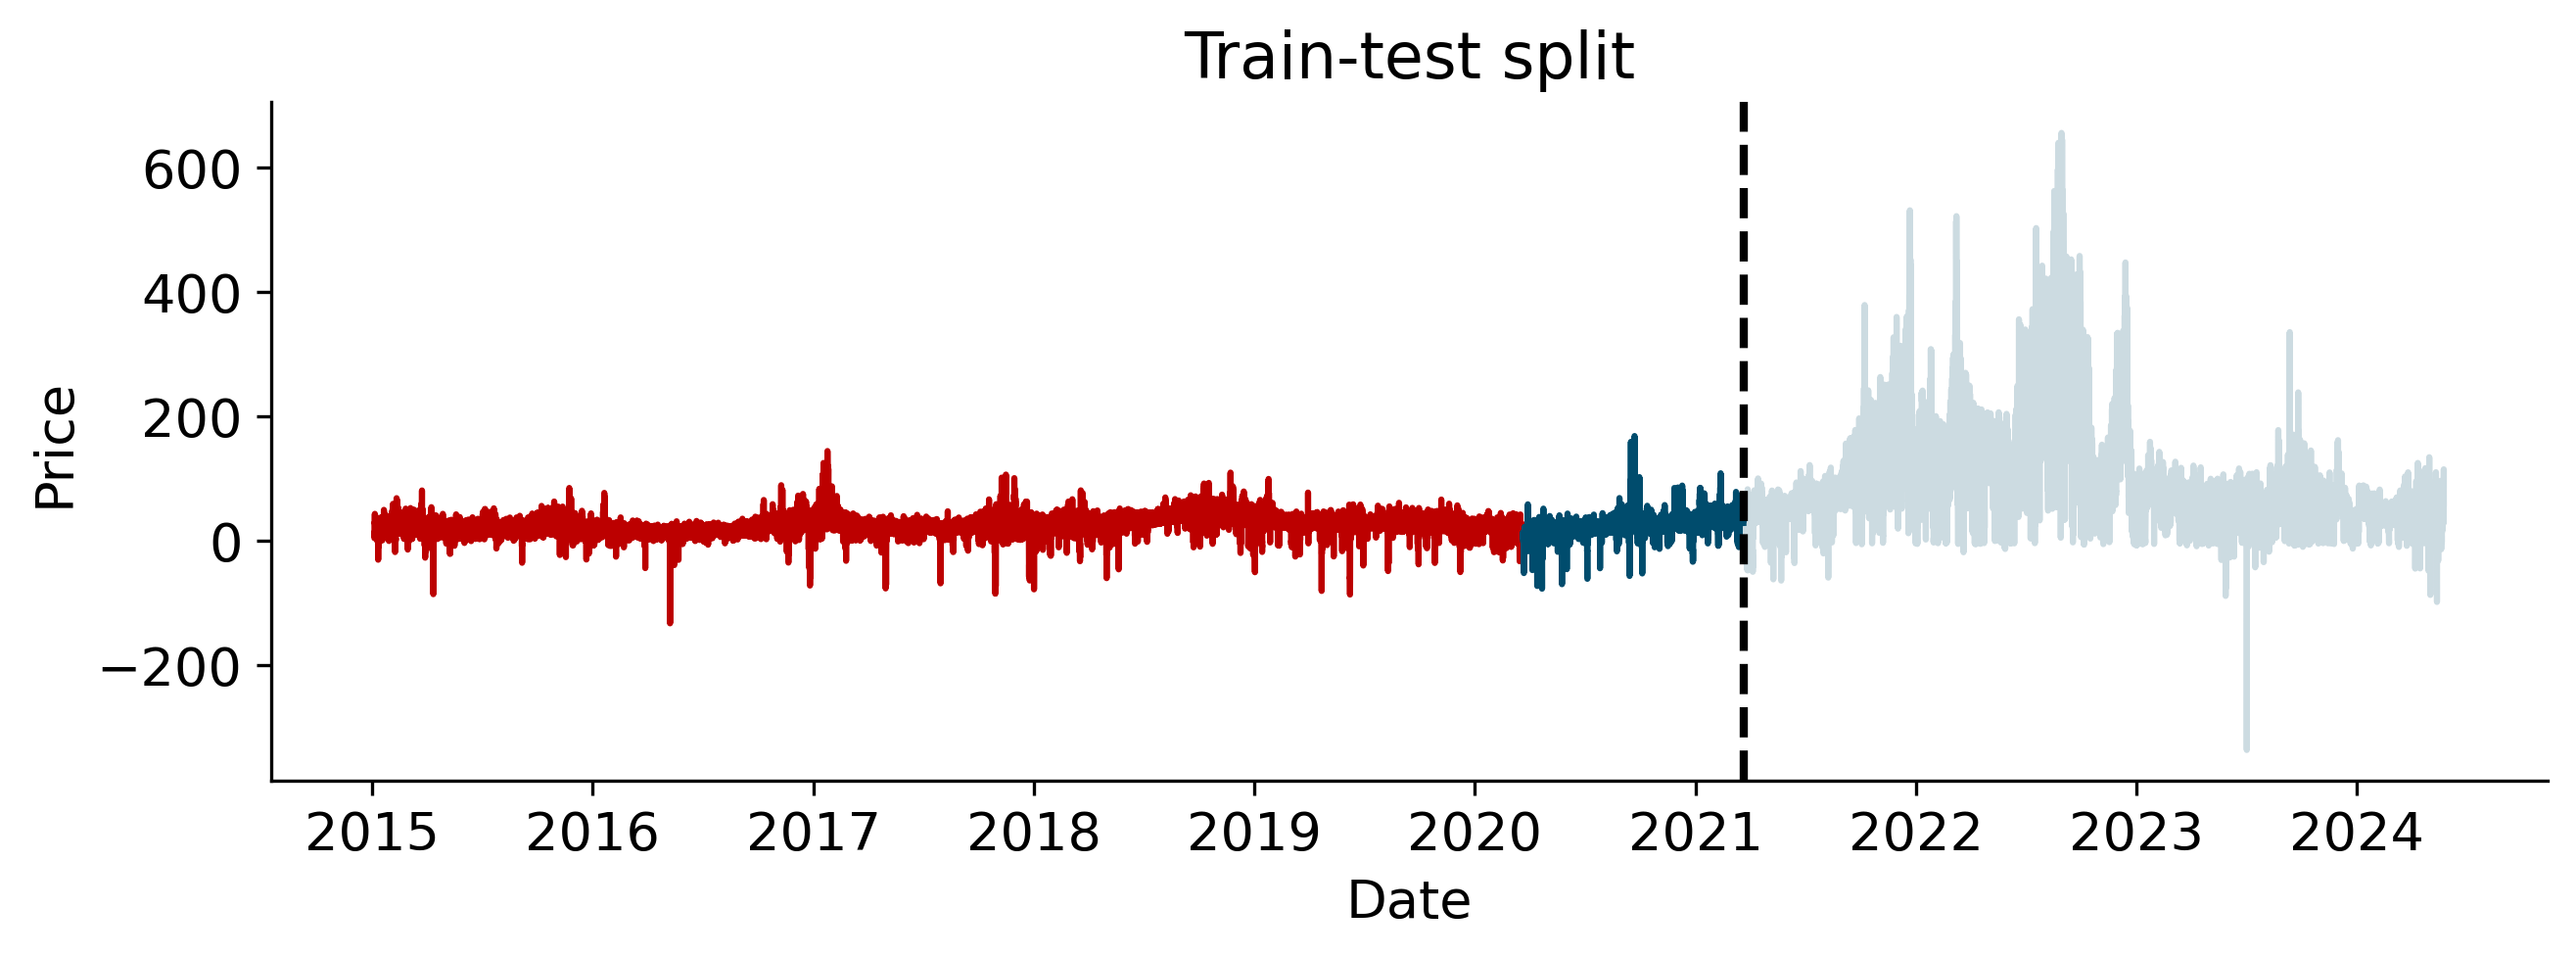

In [25]:
plt.figure(figsize = (10,3), dpi = 300)

plt.plot(train_subset_df['Germany_Luxembourg_co2_adjusted'], color = '#bc0000')
plt.plot(validation_df['Germany_Luxembourg_co2_adjusted'], color = '#004c6d')
plt.plot(target_df['Germany_Luxembourg_co2_adjusted'], color = '#004c6d', alpha = 0.2)
plt.axvline(target_df.index.min(), linewidth = 2, color = '#000000', linestyle = '--')
plt.title('Train-test split')
plt.ylabel('Price')
plt.xlabel('Date')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

My target is the column Germany_Luxembourg_adjusted_co2, this remains the same in all models, so we define this at the beginning

In [26]:
TARGET = ['Germany_Luxembourg_co2_adjusted']

In [27]:
train_subset_df = date_feature_creator(train_subset_df)
train_subset_df =add_seasonal_difference(train_subset_df)
train_subset_df = trend_seasonal_decompostion(train_subset_df)
validation_df = date_feature_creator(validation_df)
validation_df =add_seasonal_difference(validation_df)
validation_df = trend_seasonal_decompostion(validation_df)

In [28]:
target_df = date_feature_creator(target_df)
target_df =add_seasonal_difference(target_df)
target_df = trend_seasonal_decompostion(target_df)

### SARIMAX <a class="anchor" id="heading-3"></a>

In [29]:
FEATURES_1 = ['Trend','Seasonal','Noise']

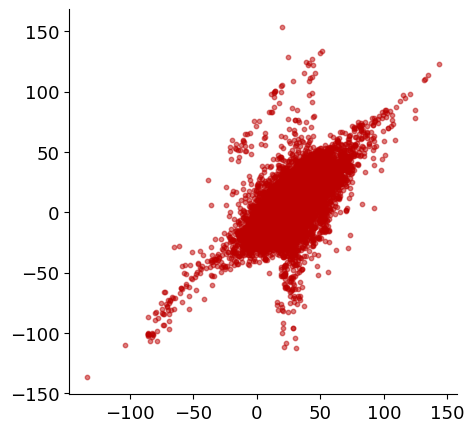

In [30]:
plt.figure(figsize=(5,5), dpi=100)
plt.scatter(x=train_subset_df['lag364'],y=train_subset_df['lag364'].diff(8760), color='#bc0000', s= 10, alpha=0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

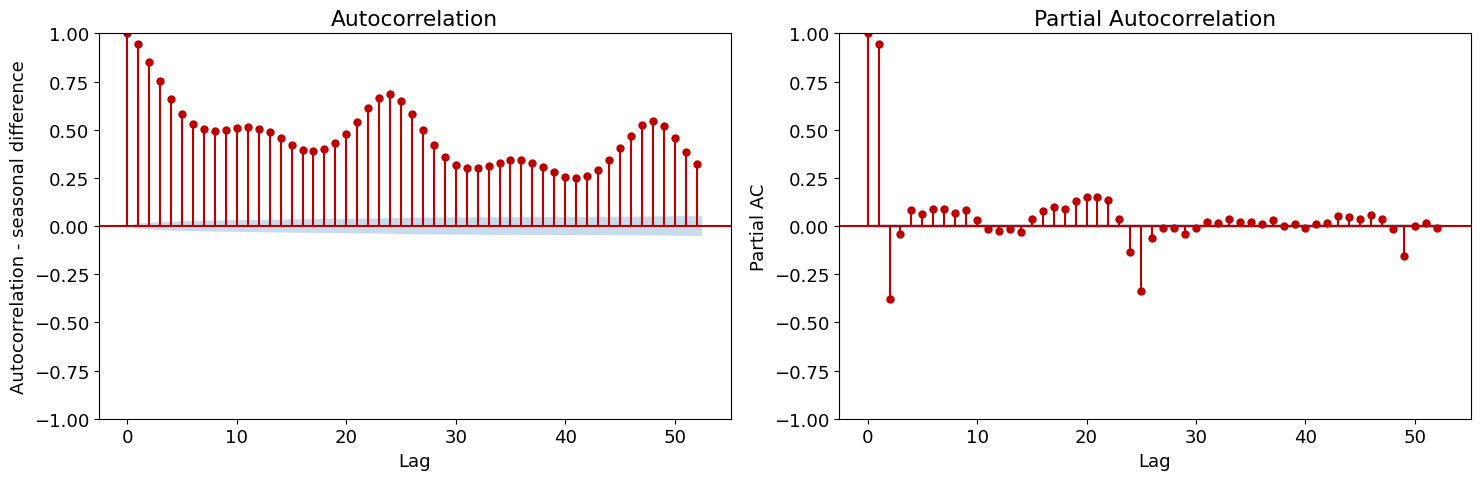

In [31]:

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# autocorrelation
plot_acf(train_subset_df['lag364'].dropna(), lags=52, ax=axs[0], color= '#bc0000', vlines_kwargs={"colors": '#bc0000'})
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation - seasonal difference')

# Partial autocorreleation
plot_pacf(train_subset_df['lag364'].dropna(), lags=52, ax=axs[1], method='ywm', color= '#bc0000', vlines_kwargs={"colors": '#bc0000'})
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial AC')

plt.tight_layout()
plt.show()


In [32]:
train_subset_model_1 = train_subset_df[~train_subset_df[FEATURES_1].isna().any(axis=1)]
# since SARIMAX models can not handle NaN values and there are some because of the seasonal-trend decomposition we exclude this rows in our dataset

In [33]:
# p_param = 3 # based on the partial autocorrelation the no. of significant lags are 3 
# d_param = 1 # to make sure that there is no stationary, increases model complexity
# q_param = 2 # size of moving average window
# P_param = 0 # to reduce model complexity it is set to 0 
# D_param = 1 # to account for a lag
# Q_param = 0 # to reduce model complexity it is set to 0 
# s = 24 # seasonality is on a 24h pattern

# reg_model_1 = SARIMAX(train_subset_model_1[TARGET],
#                     exog = train_subset_model_1[FEATURES_1],
#                     order=(p_param, d_param, q_param),
#                     seasonal_order =(P_param, D_param, Q_param, s),
#                     trend="c")
# model_1_fit = reg_model_1.fit(disp=0)

# joblib.dump(model_1_fit, '../model/model_1_fit.pkl')

In [34]:
model_1_fit = joblib.load('../model/model_1_fit.pkl')

In [35]:
print(model_1_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:     Germany_Luxembourg_co2_adjusted   No. Observations:                45624
Model:             SARIMAX(3, 1, 2)x(0, 1, [], 24)   Log Likelihood              482997.001
Date:                             Mon, 08 Jul 2024   AIC                        -965974.003
Time:                                     13:35:47   BIC                        -965886.726
Sample:                                 01-05-2015   HQIC                       -965946.546
                                      - 03-20-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.042e-08   3.09e-07     -0.293      0.770   -6.96e-07    5.15e-07
Trend          1.0000   1.6

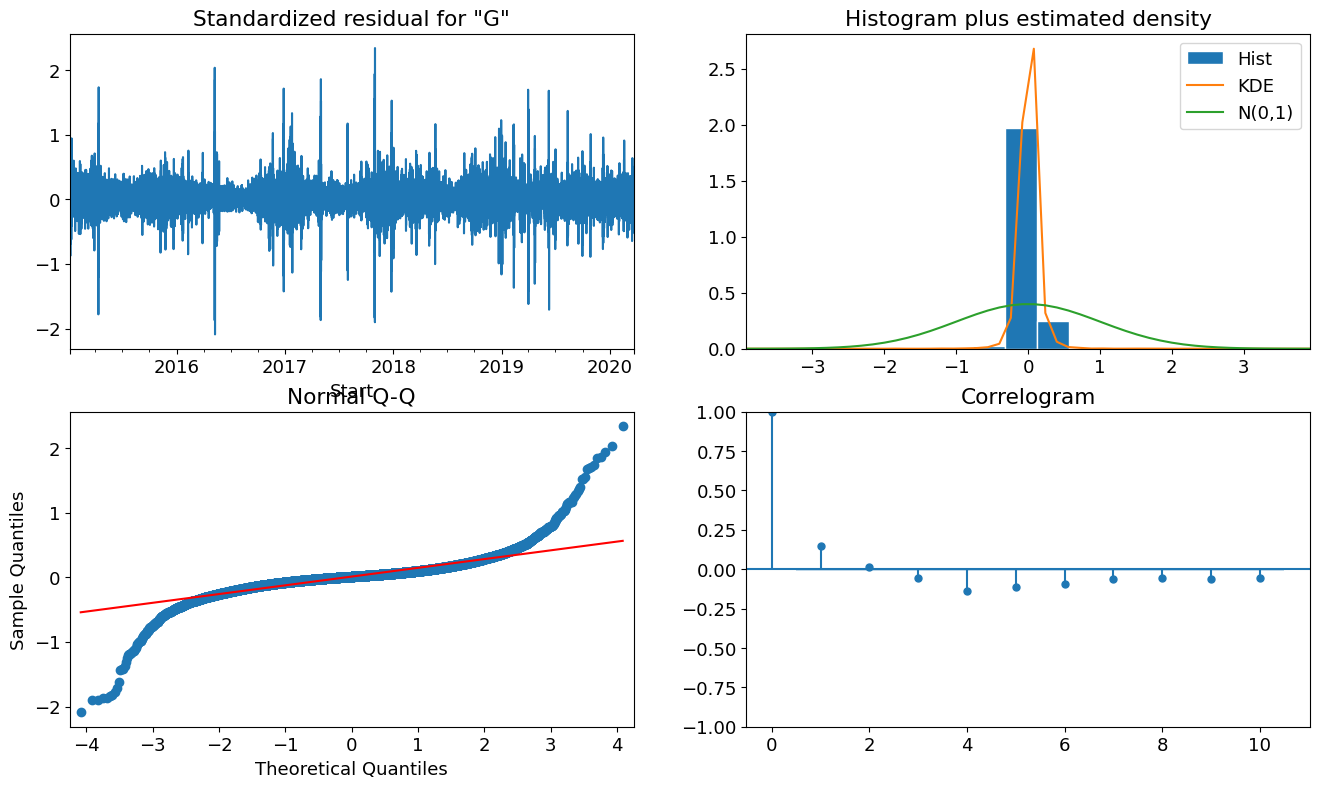

In [36]:
test = model_1_fit.plot_diagnostics(figsize=(16,9)) #it seams like the function plott and also return a plot, therefore we asign a variable

the standardised residual plot shows no clear pattern, i.e. systematic errors can be ruled out. The residuals are normally distributed. However, there are deviations at the edges of the Q-Q plot. This indicates non-normality. The correlogram also indicates that the model does not meet expectations and is not robust enough for the task. A different approach is therefore pursued. 

### Model 2: XGBBoost <a class="anchor" id="heading-3"></a>

This model will only consider price data within the zone Germany Luxembourg, therefore we created additional artificial features, XGBoost allows us, in contrast to SARIMAX, to also consider features like lags and trends that only have NaN values.

Feature choosing    
Unlike the SARIMAX model, here we will consider the lag columns and make them available to the model as features.

In [37]:
FEATURES_2 = ['hour', 'dayofweek', 'dayofyear','quarter','year','month', 'Trend', 'Seasonal', 'Noise', 'lag364','lag728', 'lag1092']

In [38]:
X_train_subset_model_2, y_train_subset_model_2 = Feature_target_seperator(train_subset_df, target =TARGET, features = FEATURES_2)
X_validation_model_2, y_validation_model_2 = Feature_target_seperator(validation_df, target =TARGET, features = FEATURES_2)

In [39]:
# reg_model_2= xgb.XGBRegressor(n_estimators = 6000, early_stopping_rounds=50, learning_rate = 0.01 )

# reg_model_2.fit(X_train_subset_model_2, y_train_subset_model_2,
#               eval_set = [(X_train_subset_model_2, y_train_subset_model_2),(X_validation_model_2, y_validation_model_2)],
#               verbose =500)

# joblib.dump(reg_model_2, '../model/reg_model_2.pkl')

This XGBoost model achieves a root-mean-square error (RSME) of 0.27818 on the train set and 1.74908 on the validation set. We see that our simple XGBBoost model performs very well within the train data period. This can be explained by the strong seasonality, the weak residuals and the relatively constant trend. We take a closer look to the feature importance..

In [40]:
reg_model_2 = joblib.load('../model/reg_model_2.pkl')

<Figure size 640x480 with 0 Axes>

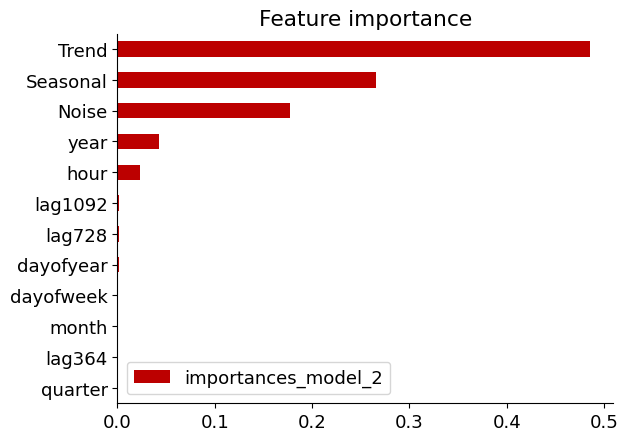

In [41]:
feature_importance_model_2 = pd.DataFrame(data =reg_model_2.feature_importances_, index = reg_model_2.feature_names_in_, columns = ['importances_model_2'])
plt.figure()
feature_importance_model_2.sort_values('importances_model_2').plot(kind='barh', title= 'Feature importance', color='#bc0000')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Trend, seasonality and residuals are the most important features. We have seen in the EDA that trend and seasonality have a specific and repeated pattern in electricity prices.  
___

#### Model 2a XGBoost with optimized features

Now we fit a model just with features which are not directly related to the TARGET.

In [42]:
FEATURES_2a = GLOABAL_FEATURES

In [43]:
X_train_subset_model_2a, y_train_subset_model_2a = Feature_target_seperator(train_subset_df, target =TARGET, features = FEATURES_2a)
X_validation_model_2a, y_validation_model_2a = Feature_target_seperator(validation_df, target =TARGET, features = FEATURES_2a)

In [44]:
# reg_model_2a= xgb.XGBRegressor(n_estimators = 6000, early_stopping_rounds=50, learning_rate = 0.01 )

# reg_model_2a.fit(X_train_subset_model_2a, y_train_subset_model_2a,
#               eval_set = [(X_train_subset_model_2a, y_train_subset_model_2a),(X_validation_model_2a, y_validation_model_2a)],
#               verbose =500)

# joblib.dump(reg_model_2a, '../model/reg_model_2a.pkl')

This XGBoost model achieves an RSME of 2.76530 on the train set and 5.77513 on the validation set. It is therefore significantly worse than the previous model. We can conclude the we need some price data in our model to make a prediction.

In [45]:
reg_model_2a = joblib.load('../model/reg_model_2a.pkl')

In [46]:
feature_importance_model_2a = pd.DataFrame(data =reg_model_2a.feature_importances_, index = reg_model_2a.feature_names_in_, columns = ['importances_model_2a'])


In [47]:
feature_importance_model_2a = feature_importance_model_2a.sort_values('importances_model_2a',ascending=True)

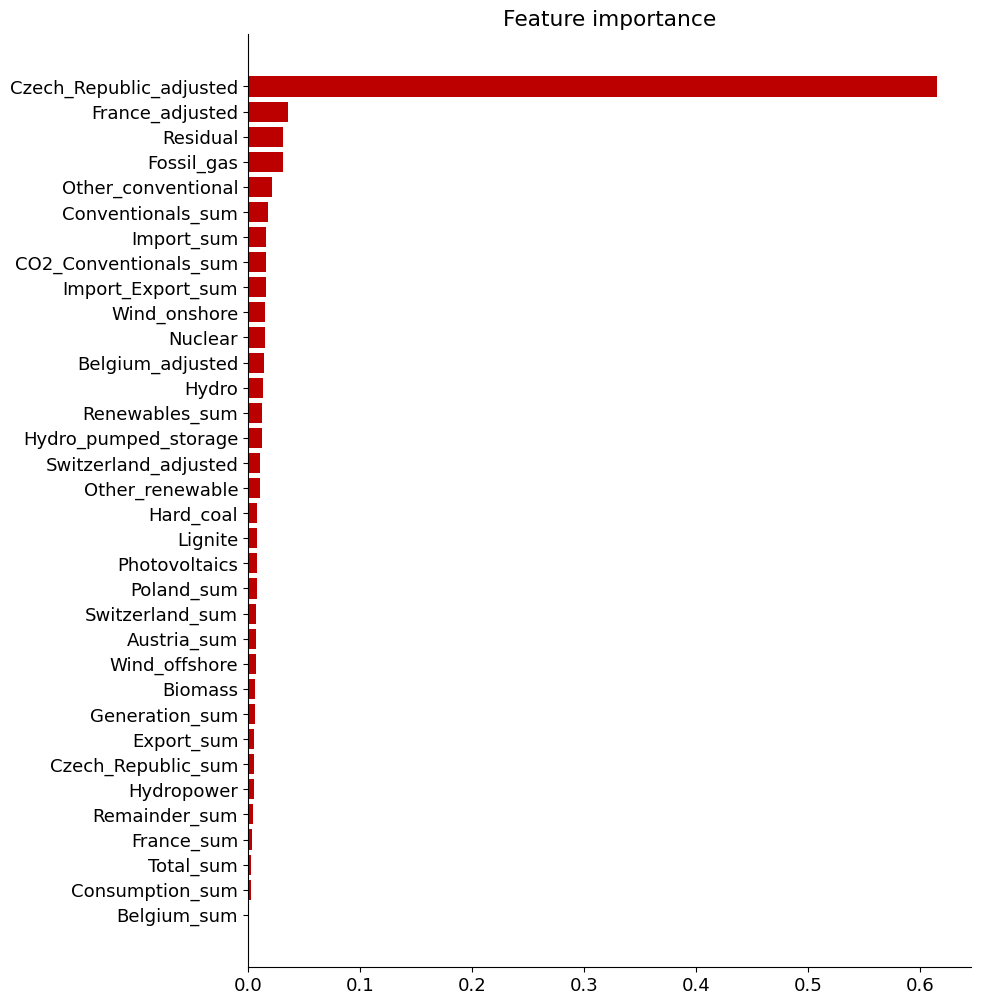

In [48]:

plt.figure(figsize = (10,10))
plt.barh(feature_importance_model_2a.index, feature_importance_model_2a['importances_model_2a'], color='#bc0000')
plt.tight_layout()
plt.title('Feature importance')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We see that the price data of the neighbouring countries have a strong feature importance, this is explainable as the prices in all regions are subject to the same fluctuations, we will remove these as features from the model. Because prices in neighboring countries also fluctuate massively in our target period, as seen in the EDA, and would therefore render our model for cost estimation unusable.

### Model 3: XGBBoost all Features <a class="anchor" id="heading-5"></a>

We extend a model with the other features from the Generation, Consumption, Import_Export dataframes and the prices from neighbouring regions and the features from model 2


We completely remove the prices of neighbouring countries. 

In [49]:
optimized_GLOBAL_FEATURES = ['Consumption_sum', 'Residual', 'Hydro',
       'Biomass', 'Hydropower', 'Wind_offshore', 'Wind_onshore',
       'Photovoltaics', 'Other_renewable', 'Nuclear', 'Lignite', 'Hard_coal',
       'Fossil_gas', 'Hydro_pumped_storage', 'Other_conventional',
       'Generation_sum', 'Import_Export_sum', 'Export_sum', 'Import_sum',
       'Belgium_sum', 'France_sum', 'Poland_sum', 'Austria_sum',
       'Czech_Republic_sum', 'Switzerland_sum', 'Remainder_sum', 'Total_sum',
       'Renewables_sum', 'CO2_Conventionals_sum', 'Conventionals_sum']


In [50]:
FEATURES_3a = FEATURES_2 + optimized_GLOBAL_FEATURES

In [51]:
X_train_subset_model_3a, y_train_subset_model_3a = Feature_target_seperator(train_subset_df, target =TARGET, features = FEATURES_3a)
X_validation_model_3a, y_validation_model_3a = Feature_target_seperator(validation_df, target =TARGET, features = FEATURES_3a)

In [52]:
# reg_model_3a= xgb.XGBRegressor(n_estimators = 10000, early_stopping_rounds=50, learning_rate = 0.01 )

# reg_model_3a.fit(X_train_subset_model_3a, y_train_subset_model_3a,
#               eval_set = [(X_train_subset_model_3a, y_train_subset_model_3a),(X_validation_model_3a, y_validation_model_3a)],
#               verbose =500)


# joblib.dump(reg_model_3a, '../model/reg_model_3a.pkl')

We now see an RMSE of 0.28918 in the train set (Validation 0) and of 1.90668 in the validation set (Validation1).This is a deterioration of the RSME, but with an increase in its informative value.

In [53]:
reg_model_3a = joblib.load('../model/reg_model_3a.pkl')

In [54]:
feature_importance_model_3a = pd.DataFrame(data =reg_model_3a.feature_importances_, index = reg_model_3a.feature_names_in_, columns = ['importances_model_3a'])
feature_importance_model_3a = feature_importance_model_3a.sort_values('importances_model_3a',ascending=True)


To see the importance of other features than trend, seasonality and Noise we plot the feature importance without them..

In [55]:
feature_importance_model_3a_without_trend_decomp = feature_importance_model_3a.loc[~feature_importance_model_3a.index.isin(['Trend', 'Seasonal', 'Noise'])]


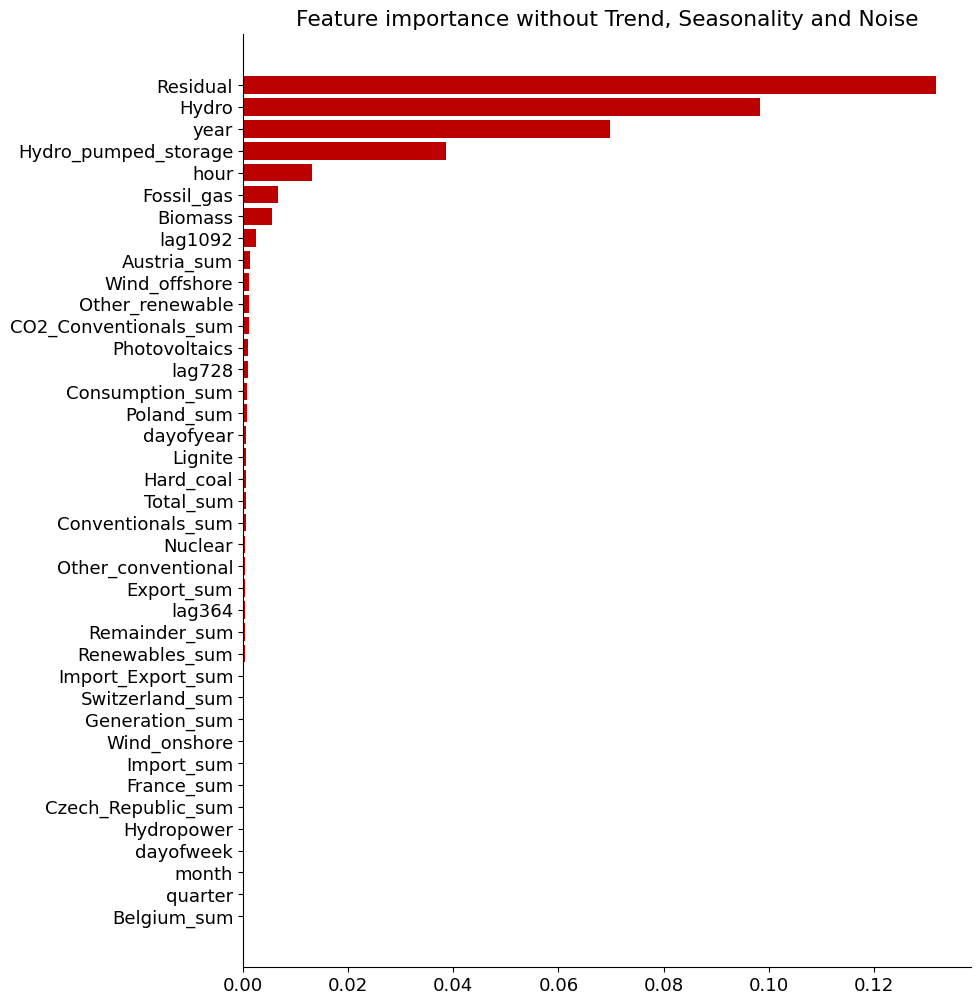

In [56]:
plt.figure(figsize = (10,10))
plt.barh(feature_importance_model_3a_without_trend_decomp.index, feature_importance_model_3a_without_trend_decomp['importances_model_3a'], color='#bc0000')
plt.tight_layout()
plt.title('Feature importance without Trend, Seasonality and Noise')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We see that the feature Residual (the base load) has the highest influence on the price, followed by hydro - in this case pumped storage power plants. This has to do with pricing and the use of these power plants in the electricity mix as peak load power plants and means that the model is taking the right approach. 


The further distribution and influence of the energy forms is also interesting. Renewables appear to have the least influence on the price, so they do not reduce the price

### Model 4: XGBBoost all Features and cross-validation <a class="anchor" id="heading-6"></a>

We therefore choose a cross-validation approach for a more robust model in order to reduce our dependency on the train-validation split and make our model more robust.

In [57]:
FEATURES_4 = FEATURES_3a

In [58]:
# feature_importance_model_4 = pd.DataFrame(index = FEATURES_4)
# tss = TimeSeriesSplit(n_splits=4, test_size=8760, gap=24) #8760h = 1 year = size of our validation
# df = train_df.sort_index()


# fold = 1
# preds = []
# scores = []
# for train_idx, val_idx in tss.split(df):
#     train = df.iloc[train_idx]
#     val = df.iloc[val_idx]

#     train = date_feature_creator(train)
#     val = date_feature_creator(val)

#     train = add_seasonal_difference(train)
#     val = add_seasonal_difference(val)

#     train = trend_seasonal_decompostion(train)
#     val = trend_seasonal_decompostion(val)
    
    

#     X_train = train[FEATURES_4]
#     y_train = train[TARGET]

#     X_val = val[FEATURES_4]
#     y_val = val[TARGET]

#     reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                            n_estimators=10000,
#                            early_stopping_rounds=50,
#                            objective='reg:linear',
#                            max_depth=3,
#                            learning_rate=0.01)
#     reg.fit(X_train, y_train,
#             eval_set=[(X_train, y_train), (X_val, y_val)],
#             verbose=1000)
    
    

#     y_pred = reg.predict(X_val)
#     preds.append(y_pred)
#     score = np.sqrt(mean_squared_error(y_val, y_pred))
#     scores.append(score)

#     print(f"Fold {fold} completed with score: {score}")
#     feature_importance_model_4[f'Fold_{fold}'] = reg.feature_importances_
#     #export the model and the scores 
#     joblib.dump(reg, f'../model/reg_model_4_{fold}.pkl')
    



#     fold += 1
    
# joblib.dump(scores, '../data/reg_model_4_scores.pkl')
# joblib.dump(preds, '../data/reg_model_4_preds.pkl')

We see a slight deterioration in the values, but we get a more robust model.

In [59]:
scores = joblib.load('../data/reg_model_4_scores.pkl')
preds = joblib.load('../data/reg_model_4_preds.pkl')

In [60]:
reg_model_4_1= joblib.load('../model/reg_model_4_1.pkl')
reg_model_4_2= joblib.load('../model/reg_model_4_2.pkl')
reg_model_4_3= joblib.load('../model/reg_model_4_3.pkl')
reg_model_4_4= joblib.load('../model/reg_model_4_4.pkl')

In [61]:
feature_importance_model_4 = pd.DataFrame(index = FEATURES_4)

In [62]:
feature_importance_model_4['Fold_1'] = reg_model_4_1.feature_importances_
feature_importance_model_4['Fold_2'] = reg_model_4_2.feature_importances_
feature_importance_model_4['Fold_3'] = reg_model_4_3.feature_importances_
feature_importance_model_4['Fold_4'] = reg_model_4_4.feature_importances_

In [63]:
feature_importance_model_4['Fold_4'] = reg_model_4_4.feature_importances_

In [64]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2.0266
Fold scores:[2.18774615844331, 3.250718444544999, 1.1201442970999278, 1.5478590359285438]


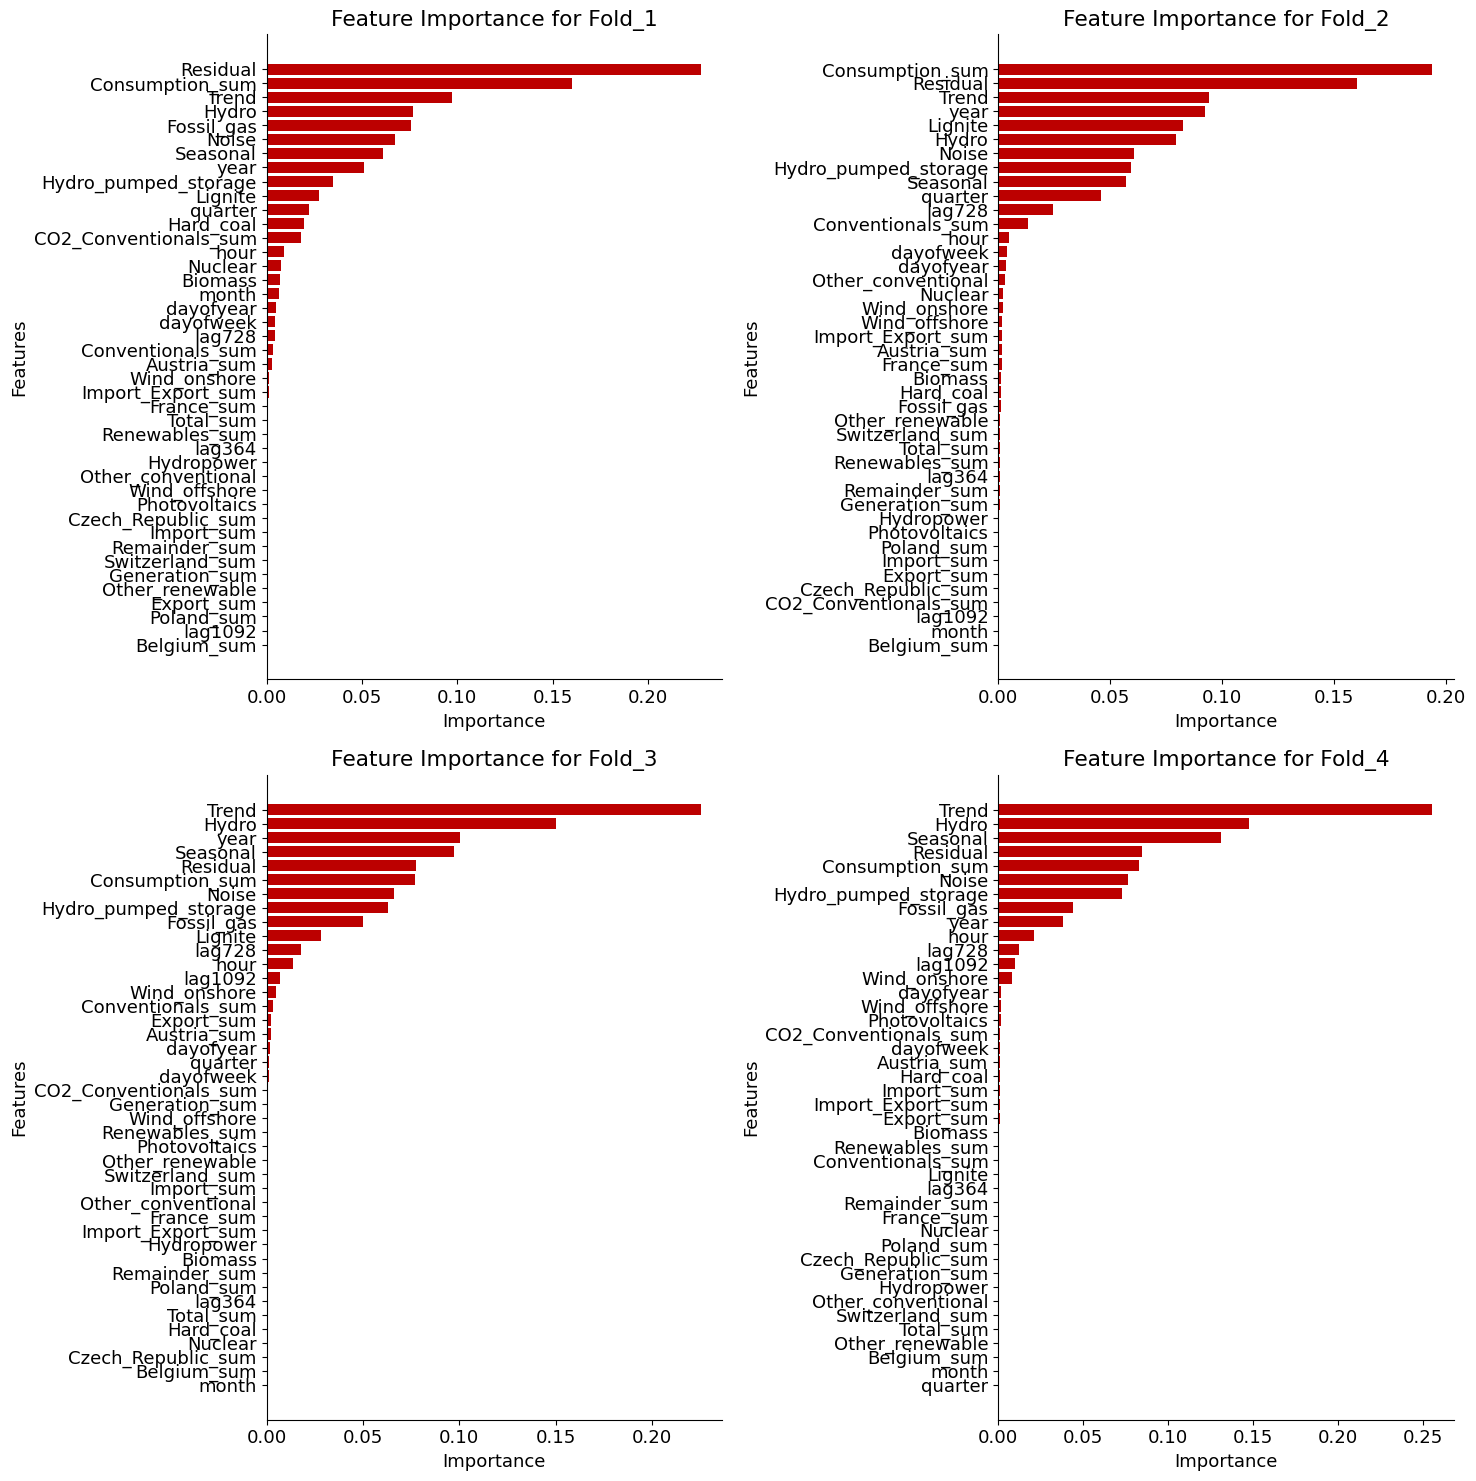

In [65]:
feature_importance_sorted = feature_importance_model_4.apply(lambda x: x.sort_values(ascending=True).index)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

for i, fold in enumerate(['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4']):
    ax = axes[i//2, i%2]
    sorted_idx = feature_importance_sorted[fold]
    ax.barh(sorted_idx, feature_importance_model_4[fold].loc[sorted_idx], color='#bc0000')
    ax.set_title(f'Feature Importance for {fold}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


plt.tight_layout()
plt.show()

We see that the feature importance varies across the folds, with pumped storage, gas and consumption alternating. However, the relatively low influence of renewables is visible in all of them. It seems that a solid base load supply (lignite in Germany) and peak power coverage are crucial for the electricity price.

### Forecast: final XGBBoost with all Features <a class="anchor" id="heading-7"></a>

We will now train our model one last time with the entire train room and then look ahead to the area of interest

In [66]:
train_df = date_feature_creator(train_df)
train_df = add_seasonal_difference(train_df)
train_df = trend_seasonal_decompostion(train_df)

In [67]:
X_train_all, y_train_all = Feature_target_seperator(train_df, FEATURES_4)

In [68]:
np.mean([6420,10000,8379,5626])

7606.25

In [69]:
# reg_model_final = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
#                            n_estimators=7600, # we use the cal avg. as max estimators, to prevent overfitting 
#                            early_stopping_rounds=50,
#                            objective='reg:linear',
#                            max_depth=3,
#                            learning_rate=0.01)
# reg_model_final.fit(X_train_all, y_train_all,
#         eval_set=[(X_train_all, y_train_all)],
#         verbose=500)


# joblib.dump(reg_model_final, '../model/reg_model_final.pkl')

We now see an RMSE of 0.42555. This is our model which we use to predict into the target area. This RSME is very low. 

In [70]:
reg_model_final = joblib.load('../model/reg_model_final.pkl')

In [71]:
feature_importance_model_final = pd.DataFrame(data =reg_model_final.feature_importances_, index = reg_model_final.feature_names_in_, columns = ['importances_model_final'])
feature_importance_model_final = feature_importance_model_final.sort_values('importances_model_final',ascending=True)


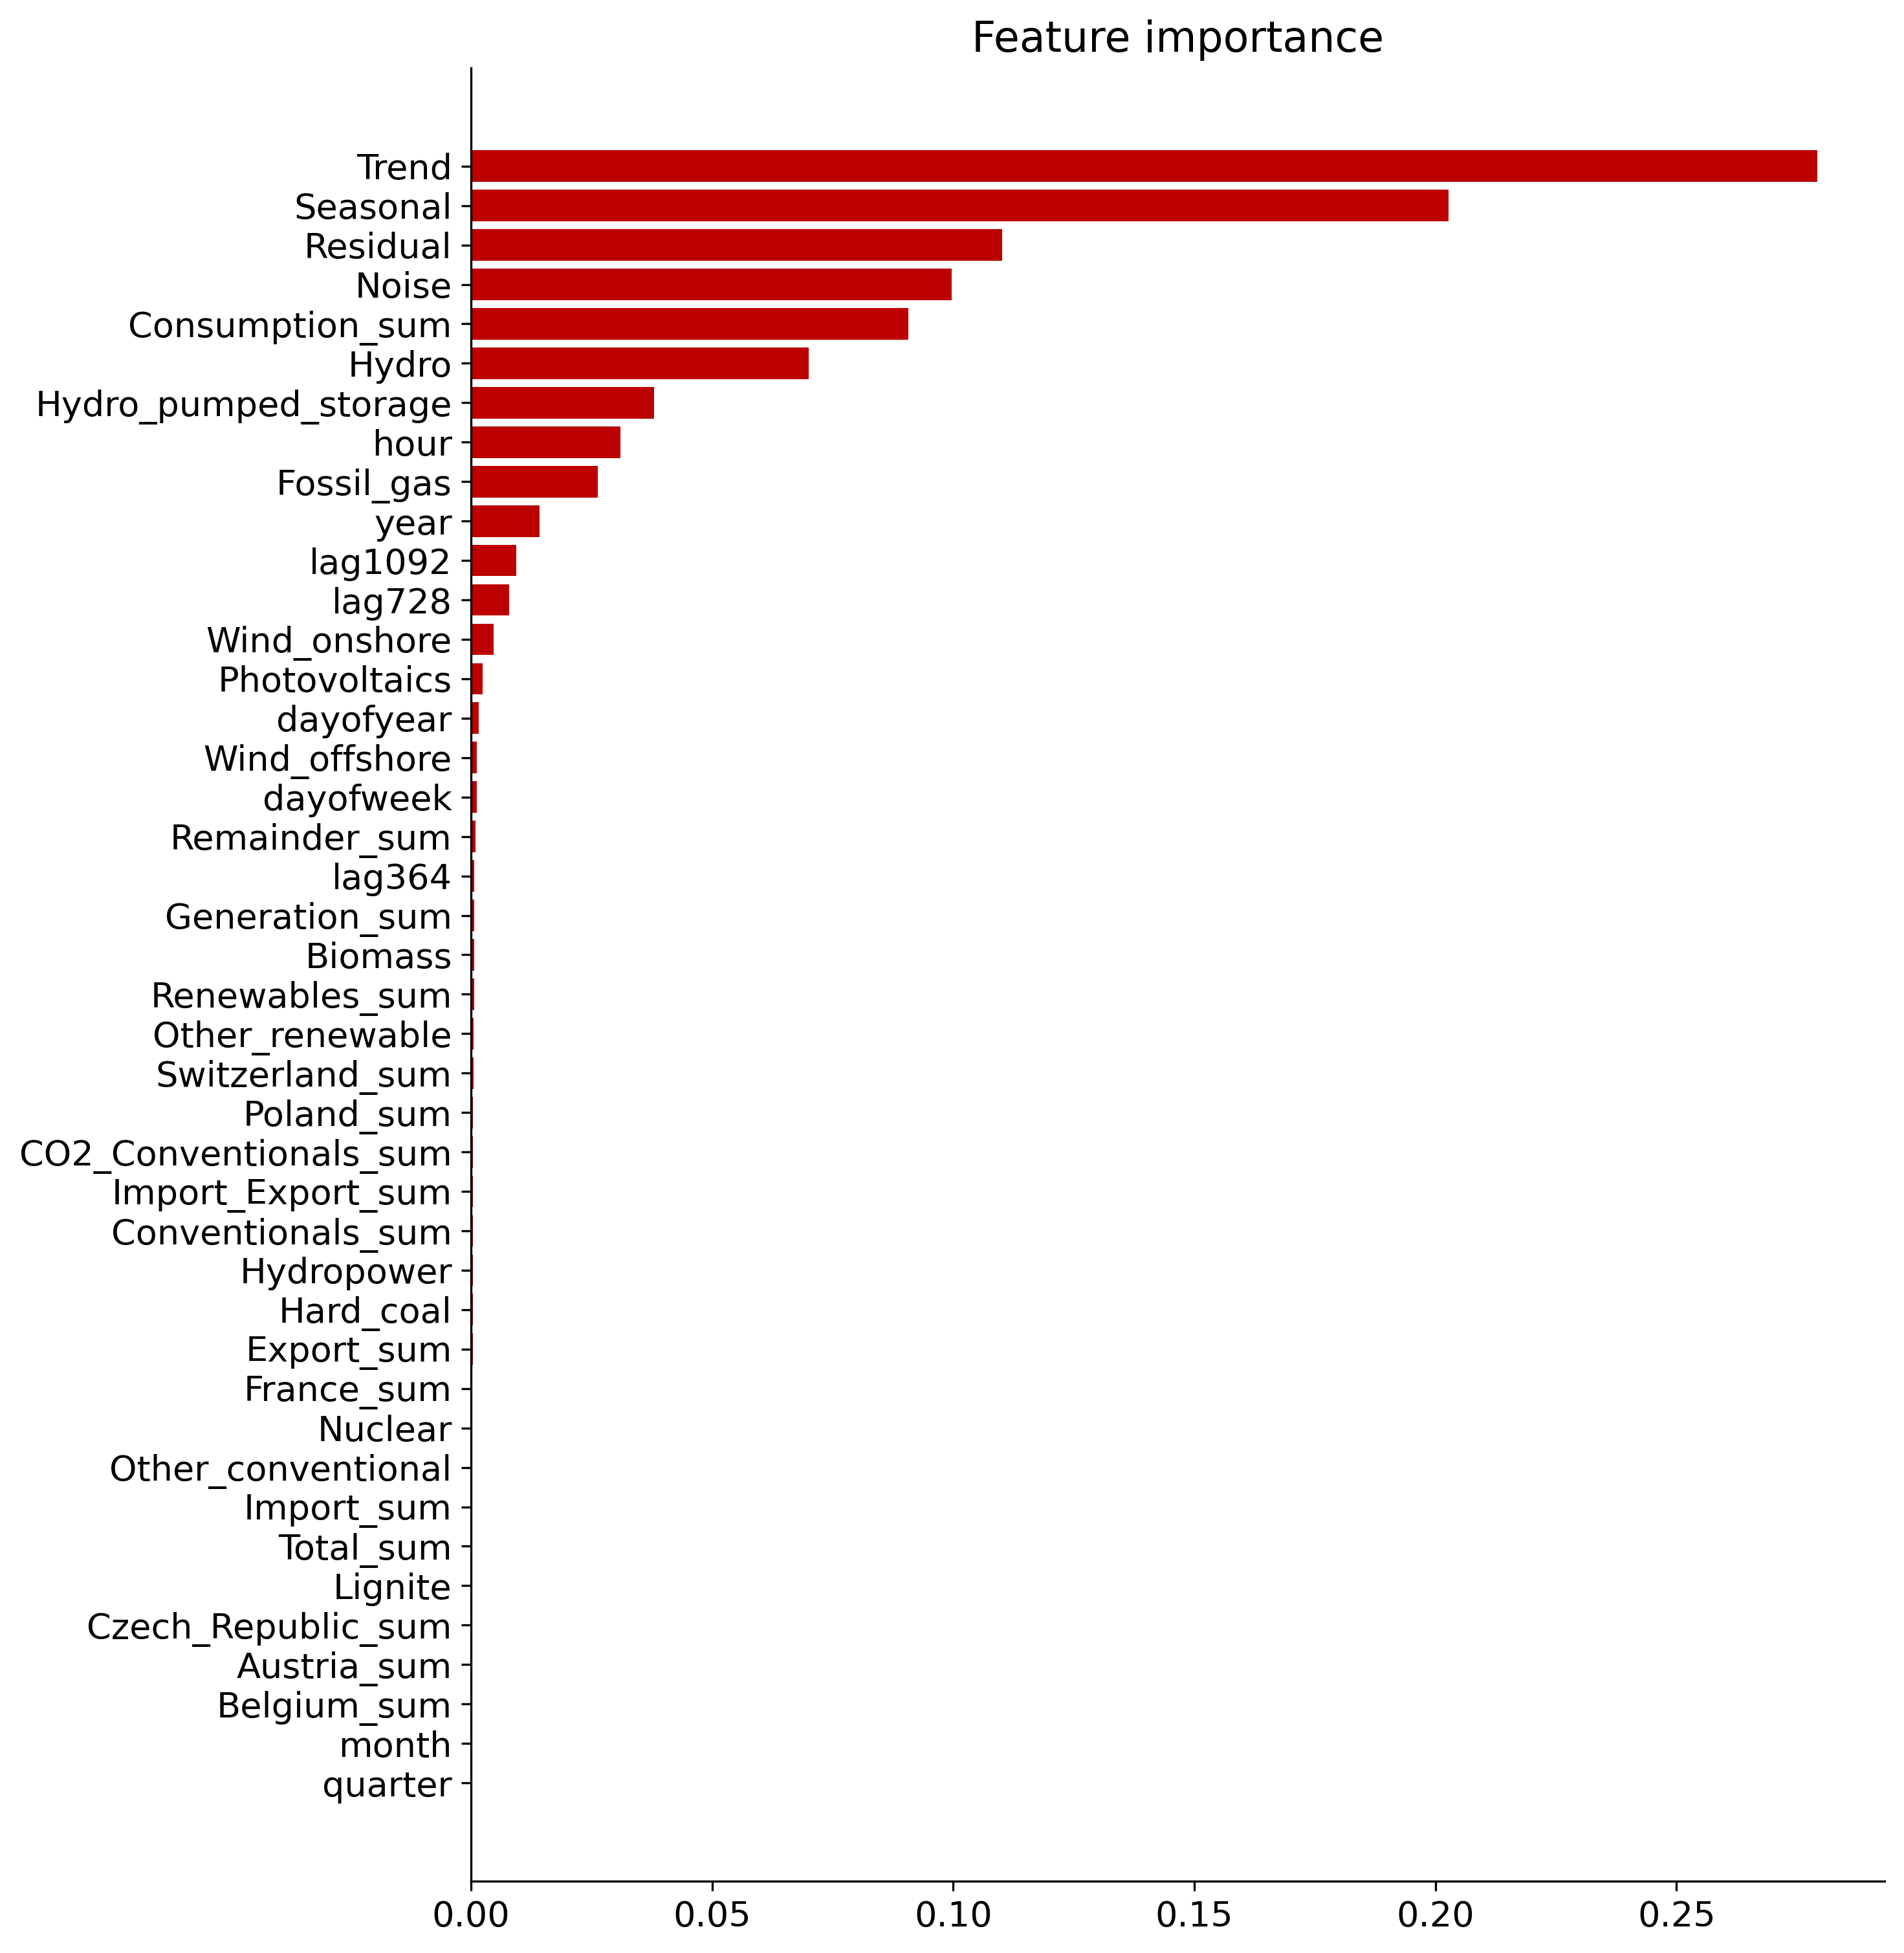

In [72]:
plt.figure(figsize = (10,10), dpi = 300)
plt.barh(feature_importance_model_final.index, feature_importance_model_final['importances_model_final'], color='#bc0000')
plt.tight_layout()
plt.title('Feature importance')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

Beside the trend, seasonality and noise - Consumption, hydro (pumped storage), base load (residual), CO2-intensive base load and gas are the decisive features of the price. It should be noted that there is a mutual dependency between the values, so the feature importance should only be seen in relation to the overall features and not to the individual price. Nevertheless, some interesting findings can be observed:

- Renewables appear to have a smaller price influence than conventional power plants.


### Predict into target area <a class="anchor" id="heading-8"></a>

In [73]:
Prediction = target_df.copy()
Prediction['isTest'] = True
Train = train_df.copy()
Train['isTest'] = False
Prediction_area = pd.concat([Train, Prediction])
Prediction_area = date_feature_creator(Prediction_area)
Prediction_area = add_seasonal_difference(Prediction_area)
area_of_intrest = Prediction_area.query('isTest').copy()

make the prediction...

In [74]:
area_of_intrest['Predicted_price'] = reg_model_final.predict(area_of_intrest[FEATURES_4])

Quantitative values ​​cannot be used to obtain an indicator of the meaningfulness of the prediction. However, it is possible to examine the output for meaningfulness.

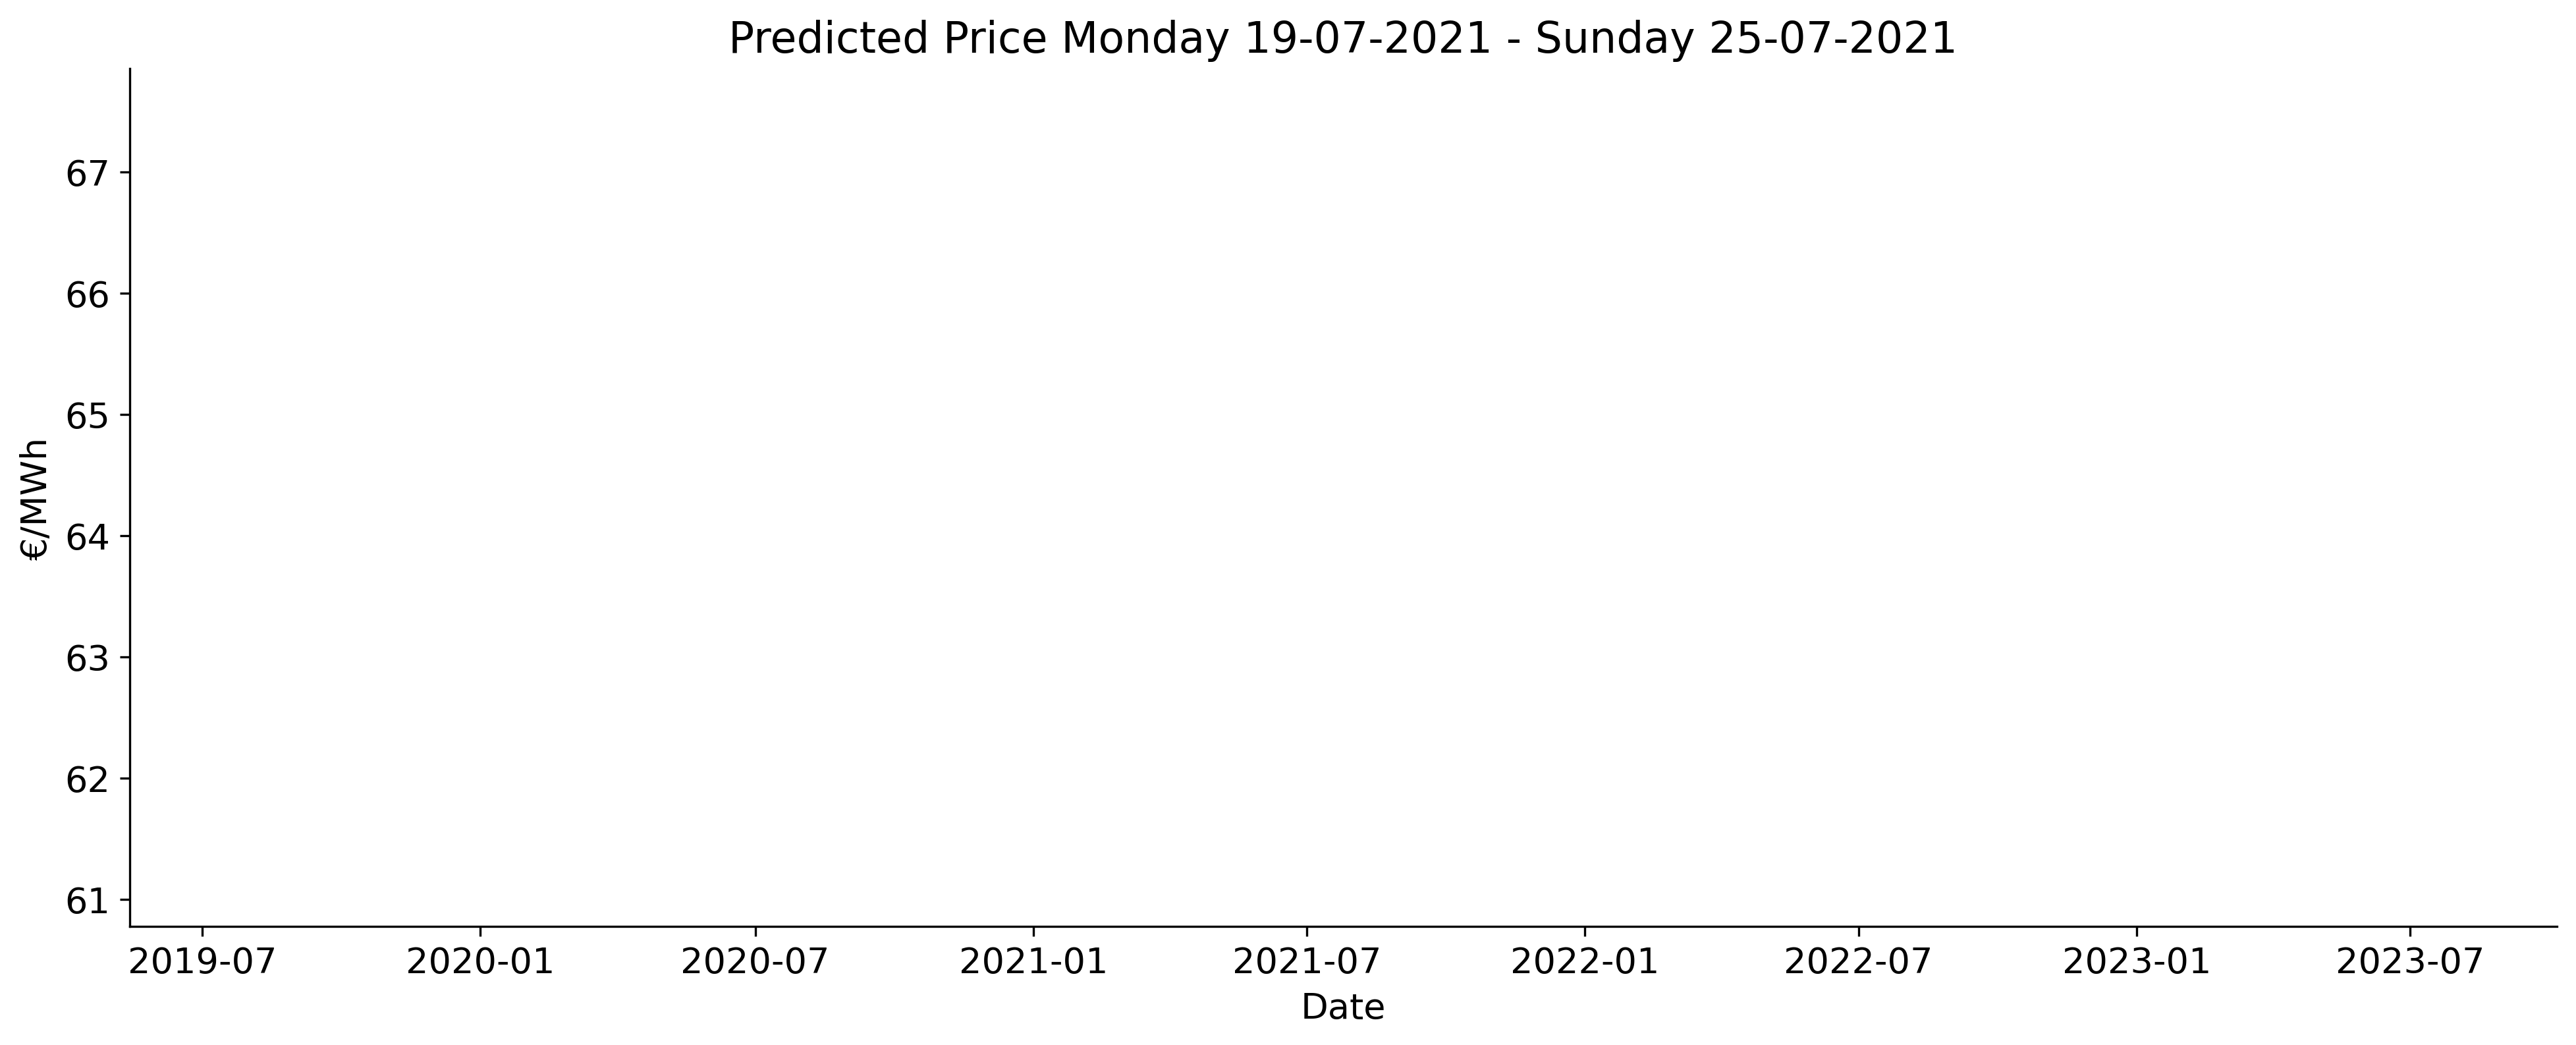

In [151]:
plt.figure(figsize = (13,5), dpi = 300)
plt.plot(area_of_intrest['Predicted_price'].loc[(area_of_intrest.index >= '2021-07-19 00:00:00')&(area_of_intrest.index <= '2021-07-25 23:00:00')], color = '#705ec9', label = 'Predicted Price')

plt.tight_layout()
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.title('Predicted Price Monday 19-07-2021 - Sunday 25-07-2021')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

We see a typical weekly electricity curve. We have the daily peaks with high demand during the day, low demand at night and a decline towards the weekend when demand for electricity drops.

for the final graphical insights, we change the frequency to weeks..

In [76]:
Predicted_price = decomposition_df(area_of_intrest, 'Predicted_price','W', 'mean')

Actual_Price = decomposition_df(area_of_intrest, 'Germany_Luxembourg_co2_adjusted','W', 'mean')
Actual_Price_in_normal_years =  decomposition_df(train_df, 'Germany_Luxembourg_co2_adjusted','W', 'mean')

In [77]:
Generation_weekly = Generation_target['Total_sum'].resample('W').sum()
Generation_weekly = pd.DataFrame(data = Generation_weekly, index = Generation_weekly.index, columns = ['Total_sum'])

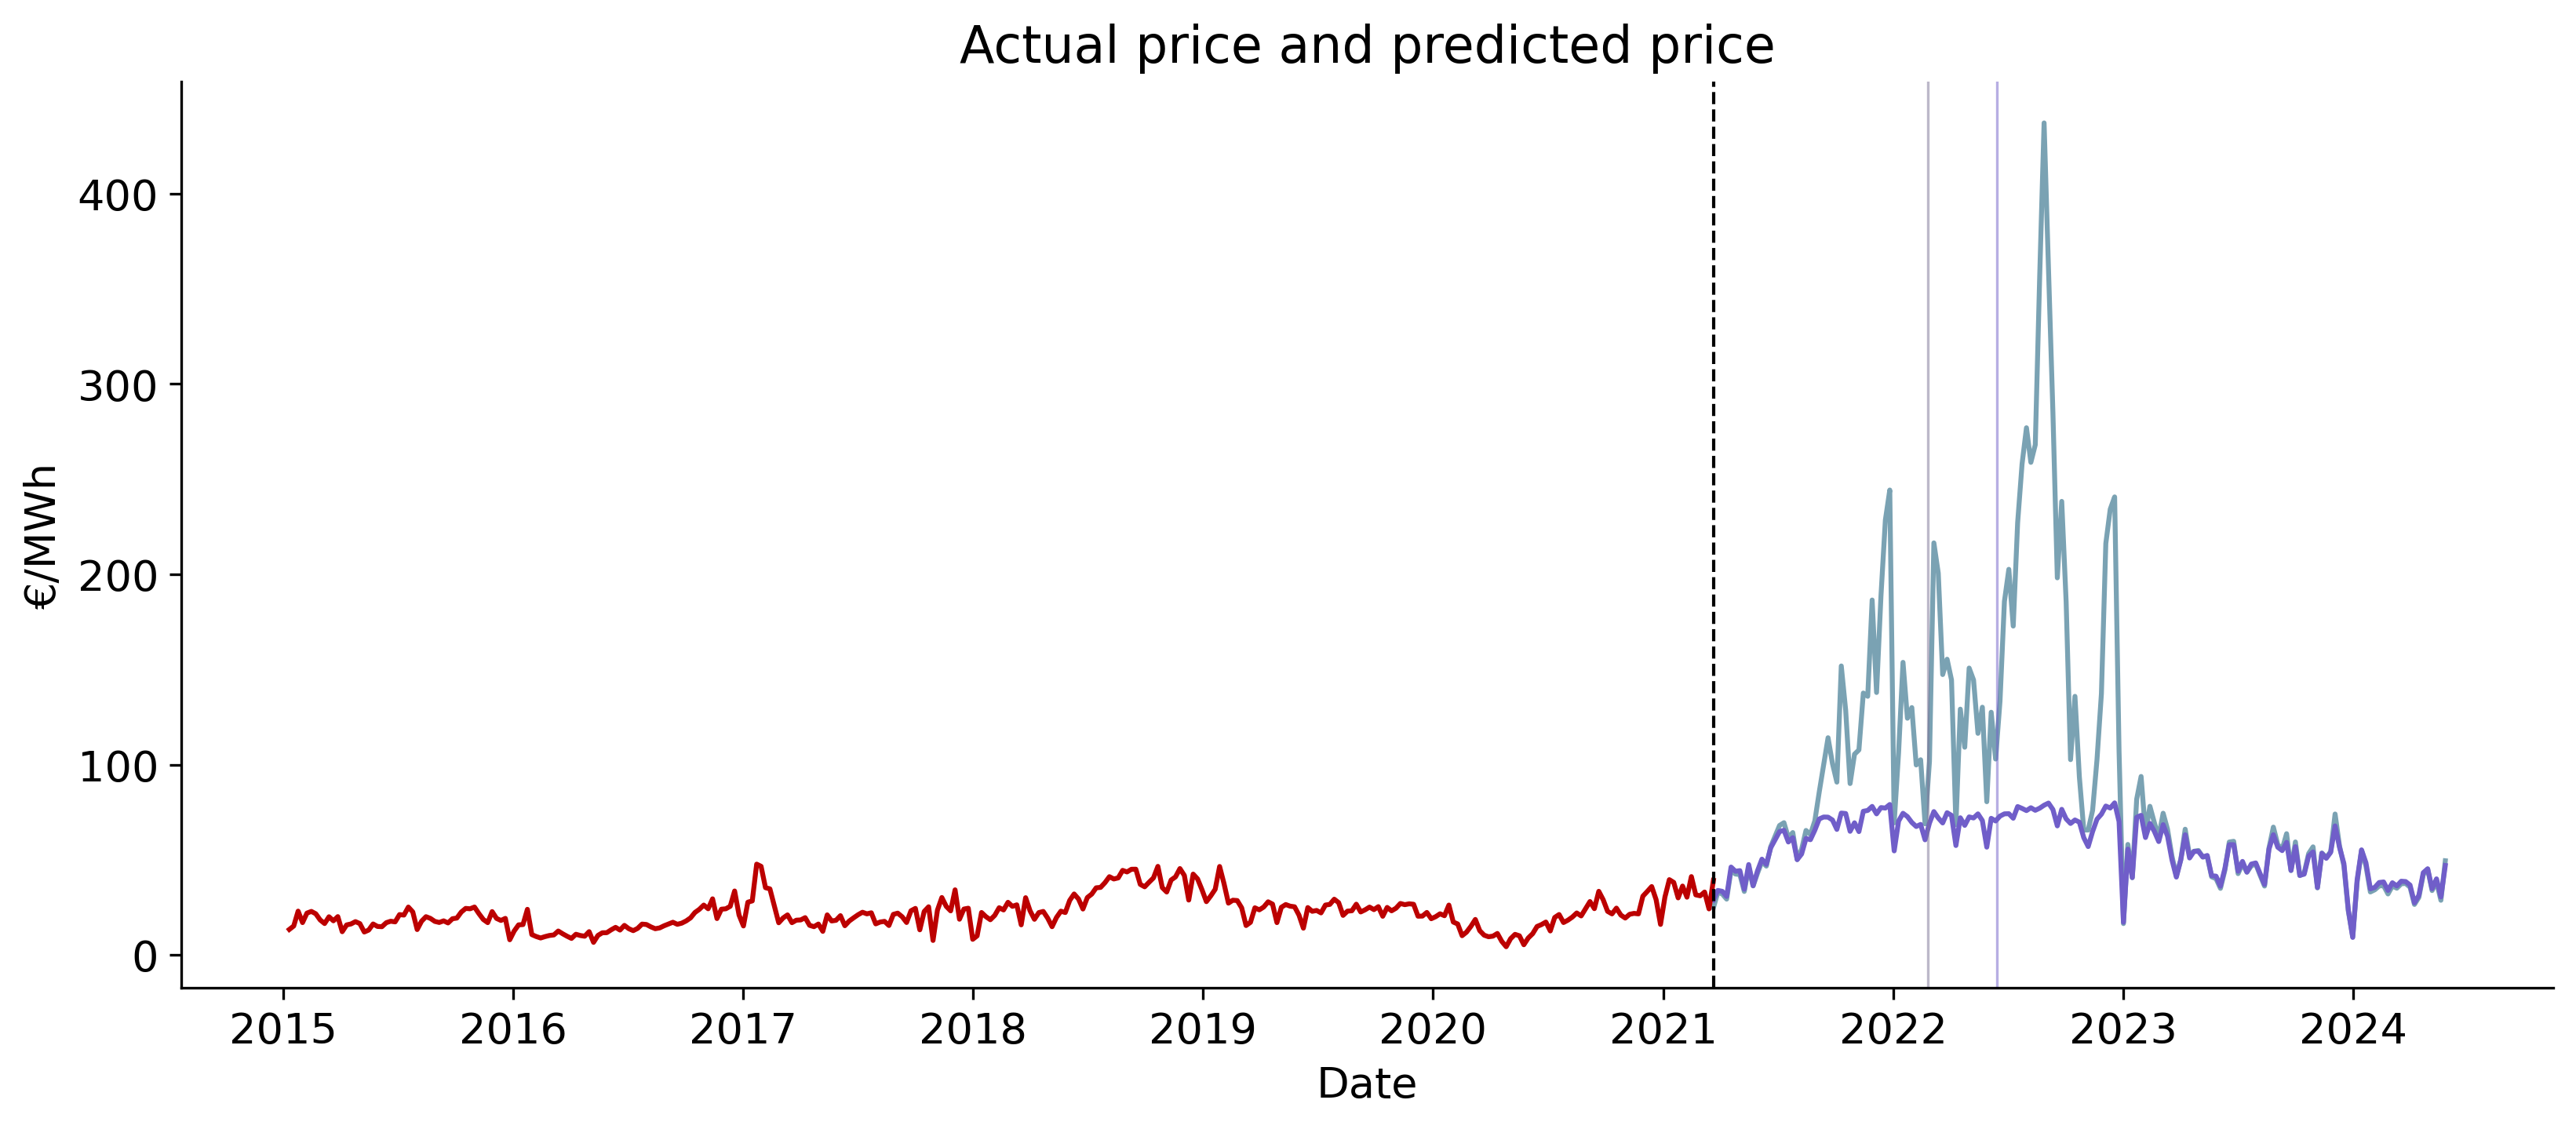

In [129]:
plt.figure(figsize= (13,5), dpi = 300)
plt.plot(Actual_Price[TARGET] , color = '#7AA2B3', label = 'Actual price')
plt.plot(Predicted_price['Predicted_price'], label = 'Predicted price XGBoost' , color = '#705ec9')

plt.plot(Actual_Price_in_normal_years[TARGET] , color = '#bc0000')


plt.axvline(x=dt.datetime(2022,2,24),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Beginn of Russia-Ukraine-War')
plt.axvline(x=dt.datetime(2022,6,14),color = '#705ec9', alpha = .5, linewidth = .8,  label = 'Beginn gas delivery disruption')
#plt.axvline(x=dt.datetime(2023,4,15),color = '#7b7294', alpha = .5, linewidth = .8,  label = 'Nuclear phase out')
plt.axvline(x=dt.datetime(2021,3,21),color = '#000000', alpha = 1, linewidth = 1,linestyle ='--',  label = 'Split')

#plt.legend()
plt.ylabel('€/MWh')
plt.xlabel('Date')
plt.title('Actual price and predicted price')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

In [153]:
Actual_Price

,Germany_Luxembourg_co2_adjusted,Trend,Seasonal,Noise,Trend+Seasonal
Start,,,,,
2021-03-21,24.801134,NaN,-27.508218,NaN,NaN
2021-03-28,32.881832,NaN,-28.131873,NaN,NaN
2021-04-04,32.058095,NaN,-28.917478,NaN,NaN
2021-04-11,29.337289,NaN,-58.226692,NaN,NaN
2021-04-18,44.556890,NaN,-33.916661,NaN,NaN
...,...,...,...,...,...
2024-04-28,45.093318,NaN,-20.742449,NaN,NaN
2024-05-05,33.831362,NaN,-24.991626,NaN,NaN
2024-05-12,38.412880,NaN,-38.128800,NaN,NaN


We see the expected price in the target period in blue and original price in black. The model picks up the general trend after Corona very well and is in line with the price again after the anomaly. This means that this price is explained in the FEATURES, ergo the difference or anomaly can now be further quantified

In [79]:
def Event_influence_adjustment(df, date):
    '''
    take a an event date, define the week of the date, create calculation columns in a dataframe and returns this as a copy of the original one
    '''
    weekdate = pd.Timestamp(date)
    week_start = weekdate - pd.DateOffset(days=weekdate.dayofweek) - pd.DateOffset(days=1)
    df = df.copy()
    df['Adjusted_prediction'] = df['Predicted_price'].loc[df.index >= week_start] + (Actual_Price['Germany_Luxembourg_co2_adjusted'].loc[Actual_Price.index == week_start][0] -df['Predicted_price'].loc[df.index == week_start][0])
    df['Difference'] = Actual_Price['Germany_Luxembourg_co2_adjusted'].loc[df.index >= week_start] - df['Adjusted_prediction']
    df['Costs'] = df['Difference'] * Generation_weekly['Total_sum'].loc[Generation_weekly.index >= week_start]
    
    return df

In [80]:
Russia_Ukraine_War = Event_influence_adjustment(Predicted_price, '2022-02-24')
Gas_Delivery_Disruption = Event_influence_adjustment(Predicted_price, '2022-06-14')


If we now want to estimate the influence of the events based on the base model, we can extrapolate from the event start point.

In [81]:
Predicted_price['Difference'] = Actual_Price['Germany_Luxembourg_co2_adjusted'] - Predicted_price['Predicted_price']
Predicted_price['Costs'] = Predicted_price['Difference'] * Generation_weekly['Total_sum']

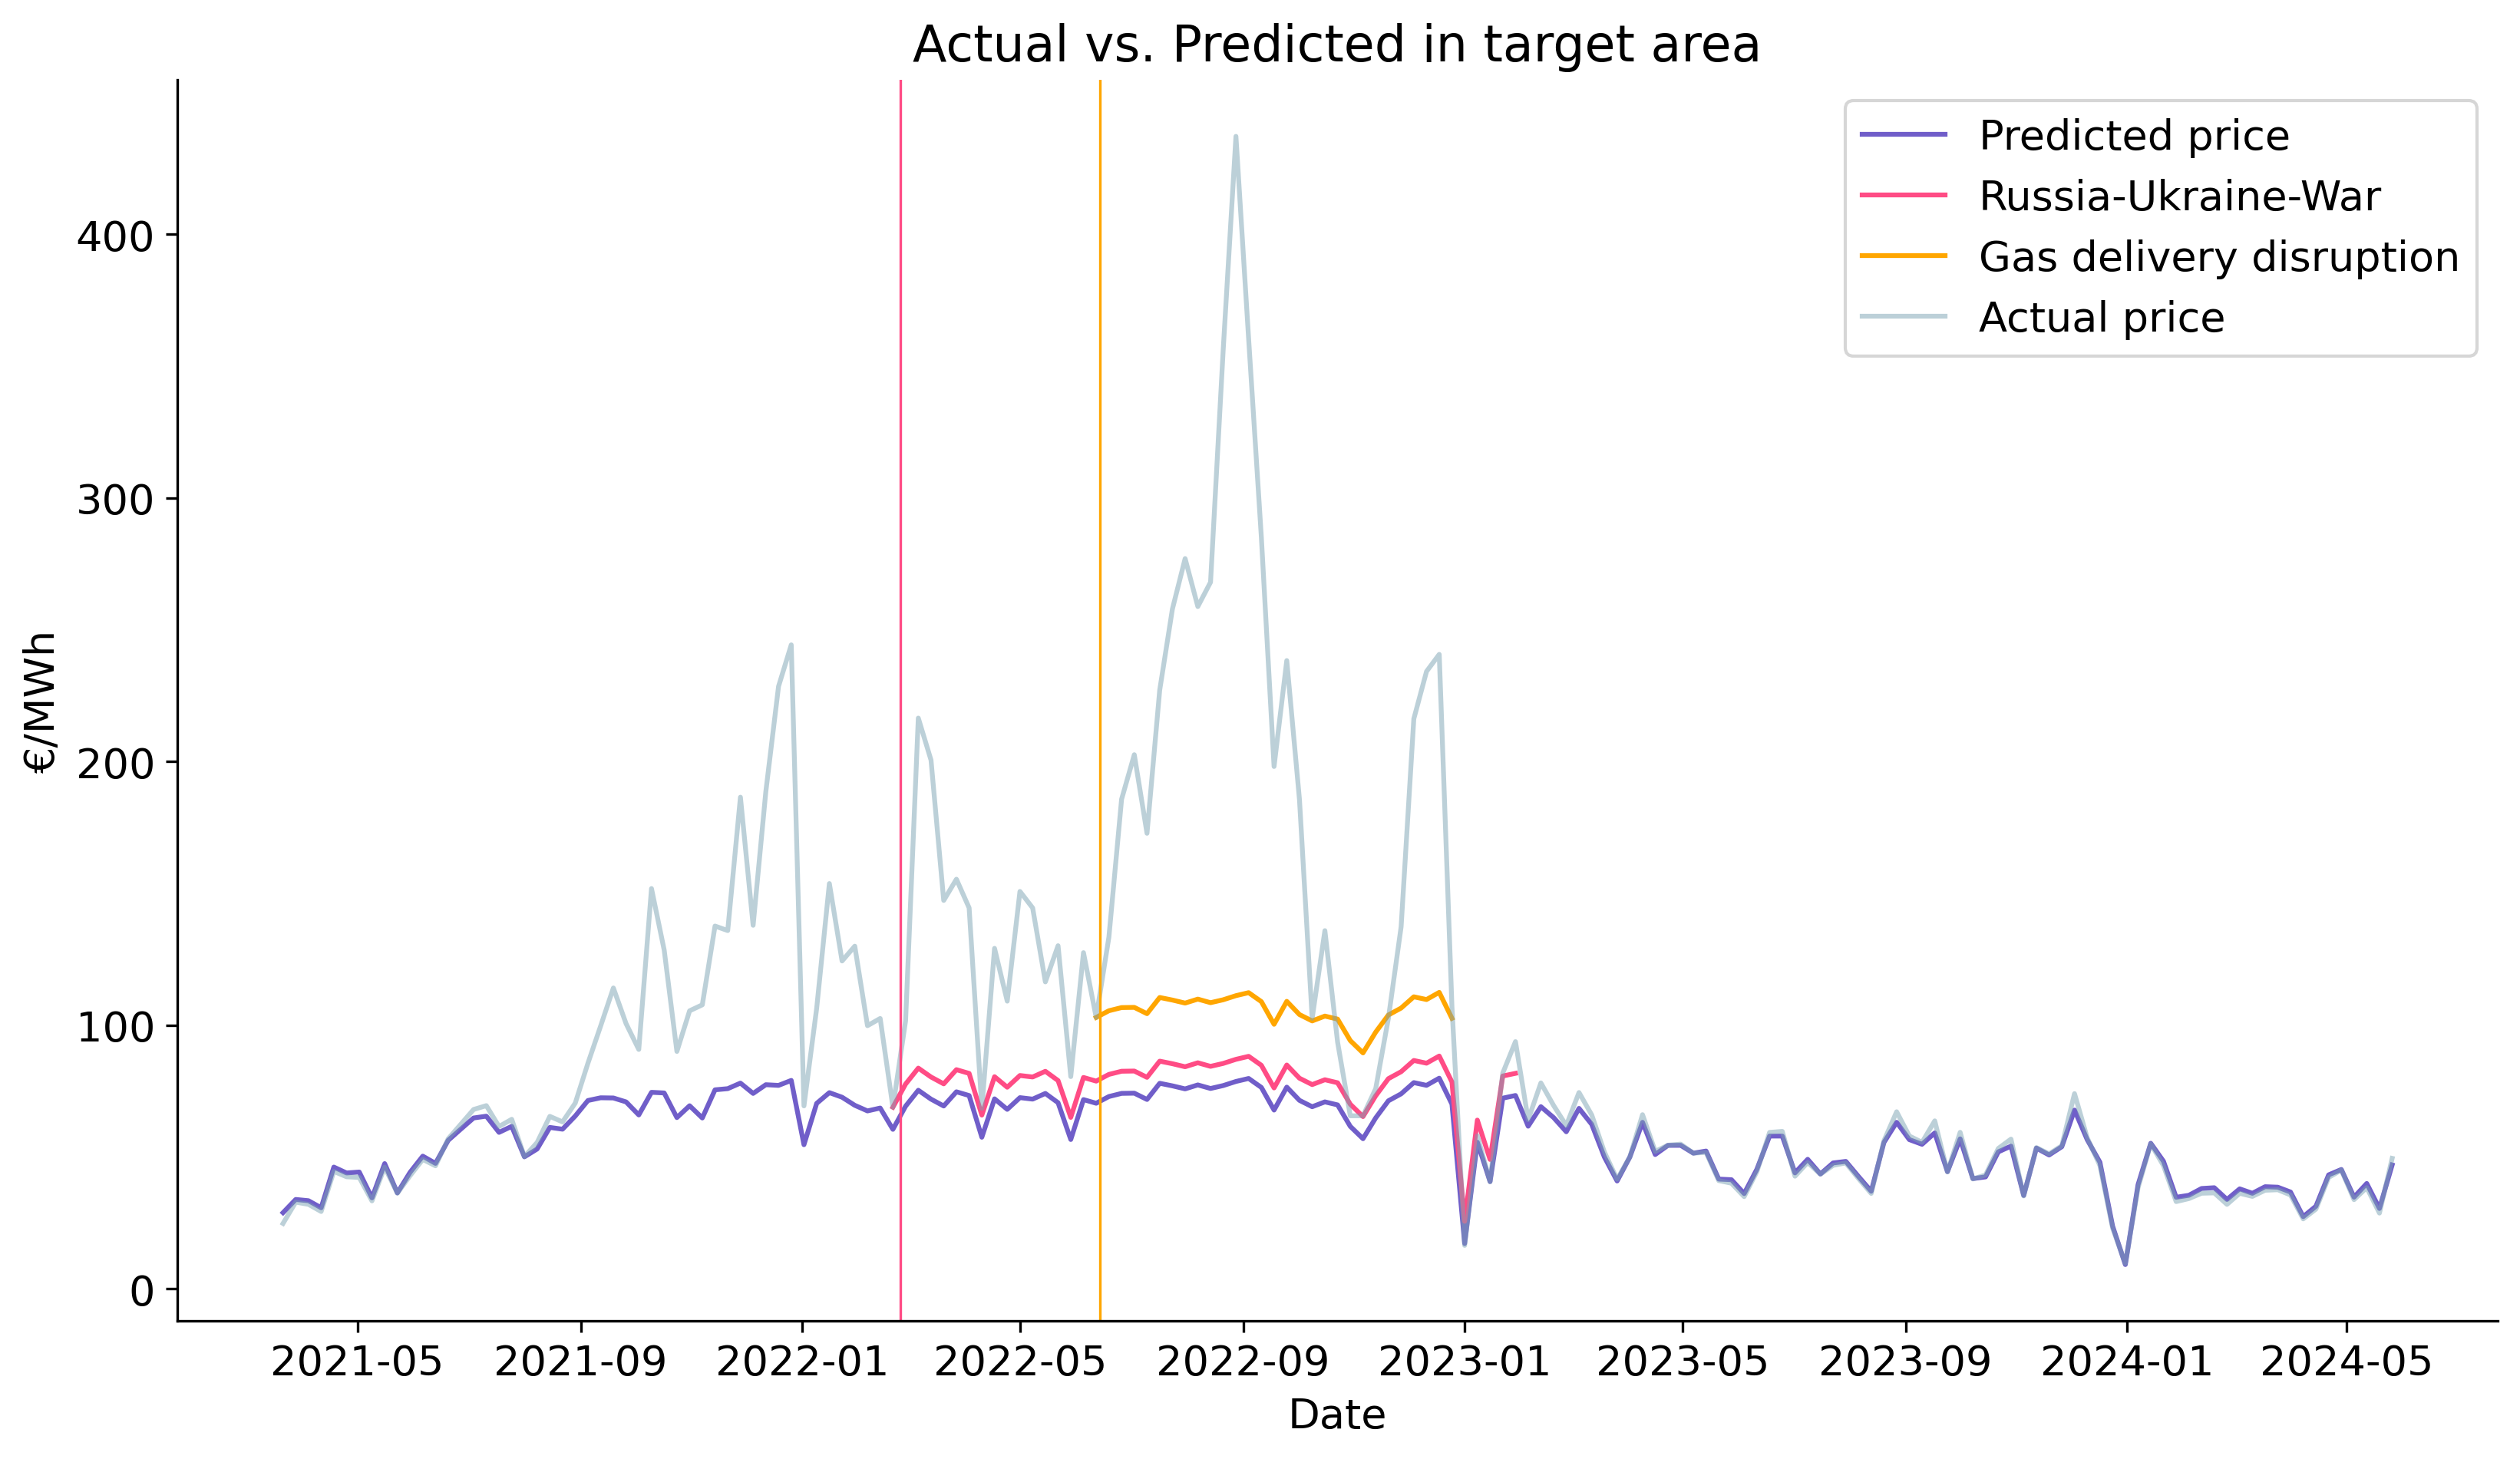

In [118]:
plt.figure(figsize= (13,7), dpi = 300)

plt.plot(Predicted_price['Predicted_price'], label = 'Predicted price' , color = '#705ec9')
plt.plot(Russia_Ukraine_War['Adjusted_prediction'].loc[Russia_Ukraine_War.index <= '2023-02-01'], color = '#ff4c85', label = 'Russia-Ukraine-War')
plt.plot(Gas_Delivery_Disruption['Adjusted_prediction'].loc[Gas_Delivery_Disruption.index <= '2022-12-25'] ,color = '#ffa600', label = 'Gas delivery disruption')
plt.plot(Actual_Price[TARGET], label = 'Actual price' , color = '#7AA2B3', alpha =0.5)


plt.axvline(x=dt.datetime(2022,2,24),color = '#ff4c85', alpha = 1, linewidth = 0.8  )#label = 'Russia-Ukraine-War'
plt.axvline(x=dt.datetime(2022,6,14),color = '#ffa600', alpha = 1, linewidth = .8 )#label = 'Gas delivery disruption'

plt.ylabel('€/MWh')
plt.xlabel('Date')

plt.legend()
plt.title('Actual vs. Predicted in target area')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

### Findings <a class="anchor" id="heading-9"></a>

We see how well the model can predict the general post-COVID rise and how well it can also predict the post-crisis period. However, we see the deviation between September 2021 and January 2023 that could not be predicted by the model, so we can call these unpredictable price outliers. The multiplication with the generation in this period enables us to make a simple estimate of the economic costs in the following

The following questions are answered:

- what are the economic costs of the anomaly from 2021?

- what are the economic costs of the Ukraine war?

- what are the economic costs of the gas crisis?



In [83]:
Anomaly_costs = (Actual_Price['Germany_Luxembourg_co2_adjusted'] - Predicted_price ['Predicted_price'])*Generation_weekly['Total_sum']
Russia_Ukraine_War_Costs = (Actual_Price['Germany_Luxembourg_co2_adjusted'] - Russia_Ukraine_War['Adjusted_prediction'])*Generation_weekly['Total_sum']
Gas_Delivery_Disruption_Costs = (Actual_Price['Germany_Luxembourg_co2_adjusted'] - Gas_Delivery_Disruption['Adjusted_prediction'])*Generation_weekly['Total_sum']
Normal_costs = Predicted_price ['Predicted_price']*Generation_weekly['Total_sum']
Total_costs = Actual_Price['Germany_Luxembourg_co2_adjusted'] * Generation_weekly['Total_sum']

In [84]:
TC = Total_costs.sum(axis=0)
NC = Normal_costs.sum(axis=0)
AC = Anomaly_costs.sum(axis=0)
RUC = Russia_Ukraine_War_Costs.loc[Russia_Ukraine_War.index <= '2023-02-01'].sum(axis=0)
GDC = Gas_Delivery_Disruption_Costs.loc[Gas_Delivery_Disruption.index <= '2022-12-25'].sum(axis=0)

In [85]:
NRC = AC - RUC #Not choosen event related costs
RUCT = RUC - GDC #Russia Ukraine War costs 

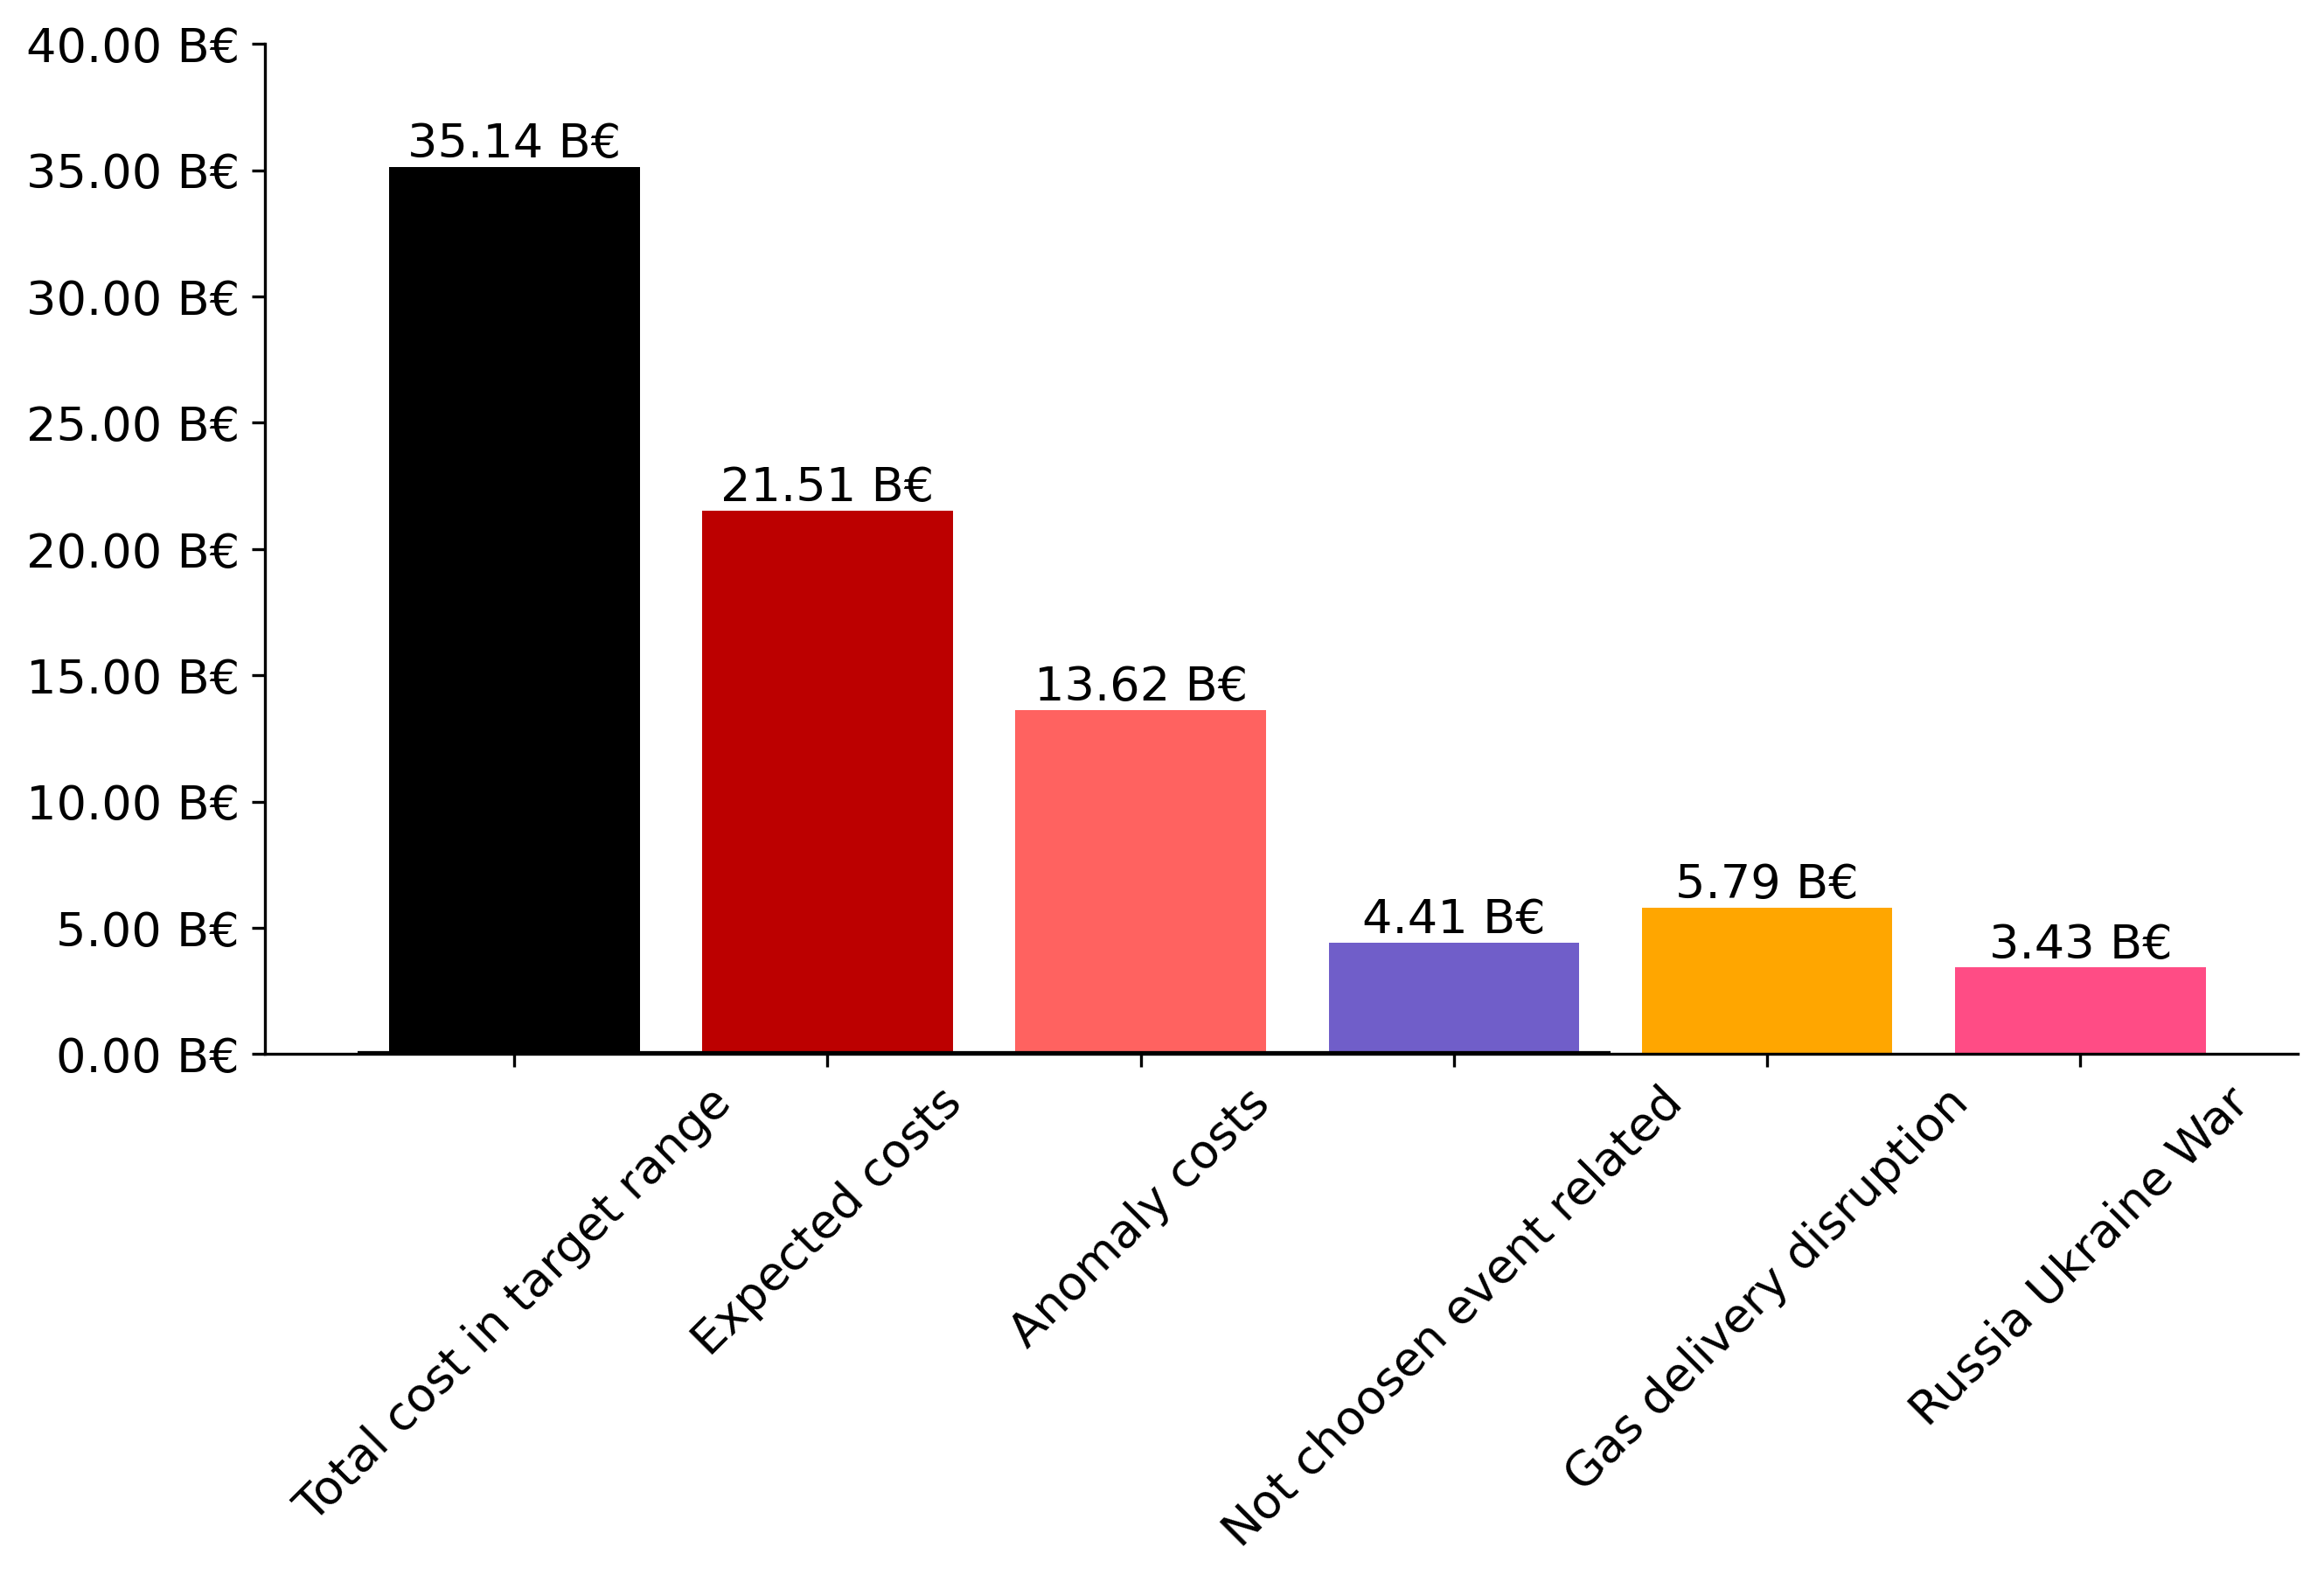

In [86]:
plt.figure(figsize=(10,5), dpi = 300)
bars = plt.bar(x= ['Total cost in target range','Expected costs','Anomaly costs','Not choosen event related','Gas delivery disruption','Russia Ukraine War'],
                height=[TC,NC, AC,NRC,GDC, RUCT],
                color = ['#000000','#bc0000','#ff6260','#705ec9','#ffa600','#ff4c85'])
plt.hlines(0, xmin= -.50, xmax=3.5, color = '#000000')
plt.yticks(np.arange(0, 45_000_000_000, 5_000_000_000))

plt.xticks(rotation = 45)
current_values = plt.gca().get_yticks()

plt.gca().set_yticklabels([f'{x/1e9:.02f} B€' for x in plt.gca().get_yticks()])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval/1e9:.02f} B€', ha='center', va='bottom')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

We can see that the anomaly accounted for around €14bn or 40% of the total costs in the target range. This in turn consists mainly of the Ukraine war with 3.4 B€ and the gas supply interruption with 5.7 B€ but there are also 4.4 B€ which are not related to either of the two events

![alt text](../images/image-7.png)

We can see how well the model predicting the price in the TARGET area. It can therefore be assumed that the FEATURES of the model can predict the price in general very well. However, from 1 September 2021 to 1 January 2023, price peaks occur that cannot be explained by the FEATURES and are therefore not represented by the final model. This is the base of the anomaly detection and we can asume that this is a price anomaly.

These peaks can be partially attributed to the two events of the start of the Ukraine-Russia war on 24/02/2022 and the gas supply interruption in summer 2022. The events also have the effect of causing a temporary spike of varying severity, but after a while they return to a predictable price range with a  higher level than before. By multiplying by the generation in the corresponding period, we can estimate the cost of the event as shown above. 


___
#### Conclusion / Next Steps

Based on this approach, further impacts can be calculated. The number of events could also be increased and a finer breakdown of this first rough approach could be pursued. The nuclear phase-out is also difficult to quantify with this model, as the shutdown was gradual and the final shutdown occurred in a calming phase after the peak of the crisis. The costs for an average household can also be calculated. The aim of this project was to practice and test the methodologies of a complete analysis. 
___

Thanks to Miranda, Jeremy and Shifath for teaching me and making this possible. 😊